# Simulate Boyajian's Star in ZTF

First, let's start with a simple simulation of Boyajian's star in ZTF:

I'm going to 
1) download the Kepler light curve for Boyajian's Star
2) download some random ZTF light curves
3) try to use the ZTF time stamps to simulate some light curves of the existing Kepler data, but with a ZTF cadence

In the second step:
4) make sure the error bars match those of ZTF for a given magnitude

In the third step, expand the simulations:
5) move the bright dips around in the ZTF observation time
6) make light curves with different median magnitude (and corresponding error bars --> make a scatter plot of light curve magnitudes and their uncertainties, define a Gaussian with the right mean and variance)
7) Maybe define a more general model for Boyajian's star-like light curves and simulate from that?

#### Open Questions
* Do we need to restrict ourselves in galactic latitude? Start by pulling $N$ random objects from across the sky

## Imports

In [2]:
!pip install lightkurve

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 492 kB 33.0 MB/s eta 0:00:01
  Using cached oktopus-0.1.2.tar.gz (10 kB)
  Using cached fbpca-1.0.tar.gz (11 kB)
  Using cached bs4-0.0.1.tar.gz (1.1 kB)
  Using cached uncertainties-3.1.2.tar.gz (232 kB)
  Using cached autograd-1.3.tar.gz (38 kB)
  Created wheel for oktopus: filename=oktopus-0.1.2-py3-none-any.whl size=12778 sha256=abe2d45862787e2957688fbc25aa221148302eb5552bb1649f0650f232096564
  Stored in directory: /astro/users/dhuppenk/.cache/pip/wheels/19/22/e3/6d224a32d6f94f28113d6d26c8bef81d7e05978d0efed29517
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11375 sha256=3abf7b7d43310f0d654ce336c79a56e427d150fabecc87c94b01b710272875fb
  Stored in directory: /astro/users/dhuppenk/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=1250d0fd2ee6

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import glob

import numpy as np
import pandas as pd
import lightkurve

## Getting the Kepler Data

We're going to get the Kepler data using the `lightkurve` package:

In [4]:
from lightkurve import search_lightcurvefile
target = 'KIC 8462852'

Let's try and download the data for all quarters. 

In [3]:
lc = search_lightcurvefile(target, quarter=1).download().PDCSAP_FLUX
for q in range(2,18):
    lc = lc.append(search_lightcurvefile(target, quarter=q).download().PDCSAP_FLUX)

KeyboardInterrupt: 

In [ ]:
lc.scatter();

The `normalize` function normalizes the different quarters to the same mean magnitude:

In [5]:
lc = search_lightcurvefile(target, quarter=1).download().PDCSAP_FLUX.normalize()
for q in range(2,18):
    lc = lc.append(search_lightcurvefile(target, quarter=q).download().PDCSAP_FLUX.normalize())

<IPython.core.display.Javascript object>


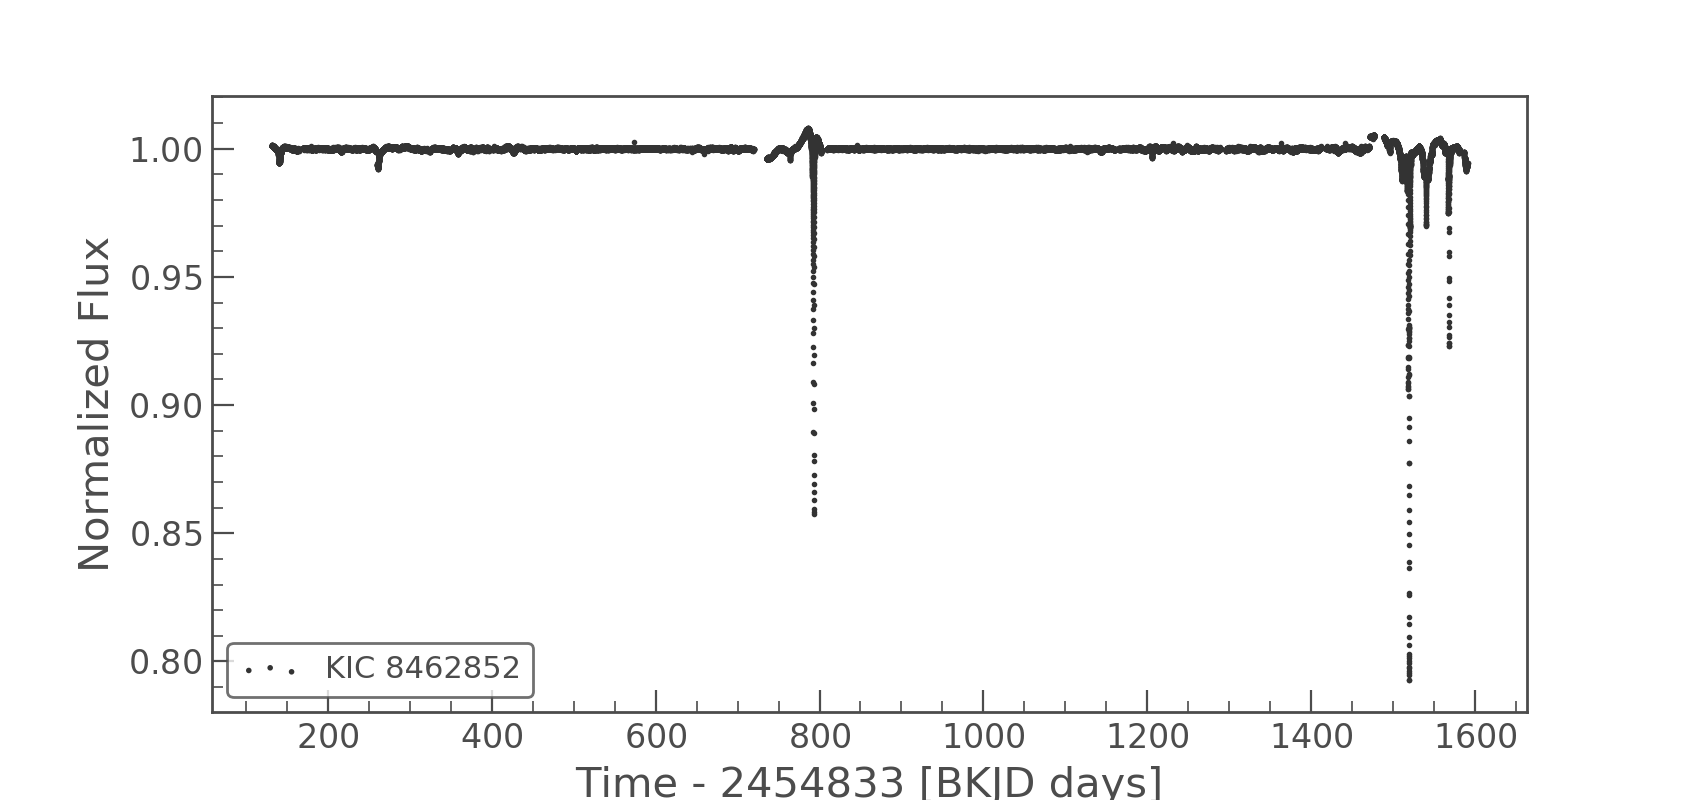

In [6]:
lc.scatter();

Let's save this to a file:

In [7]:
!pwd

/data/epyc/users/dhuppenk/repositories/ZTF_Boyajian/notebooks


In [8]:
np.savetxt("./boyajians_star_kepler_normalized.dat", np.array([lc.time, lc.flux]).T)

<IPython.core.display.Javascript object>


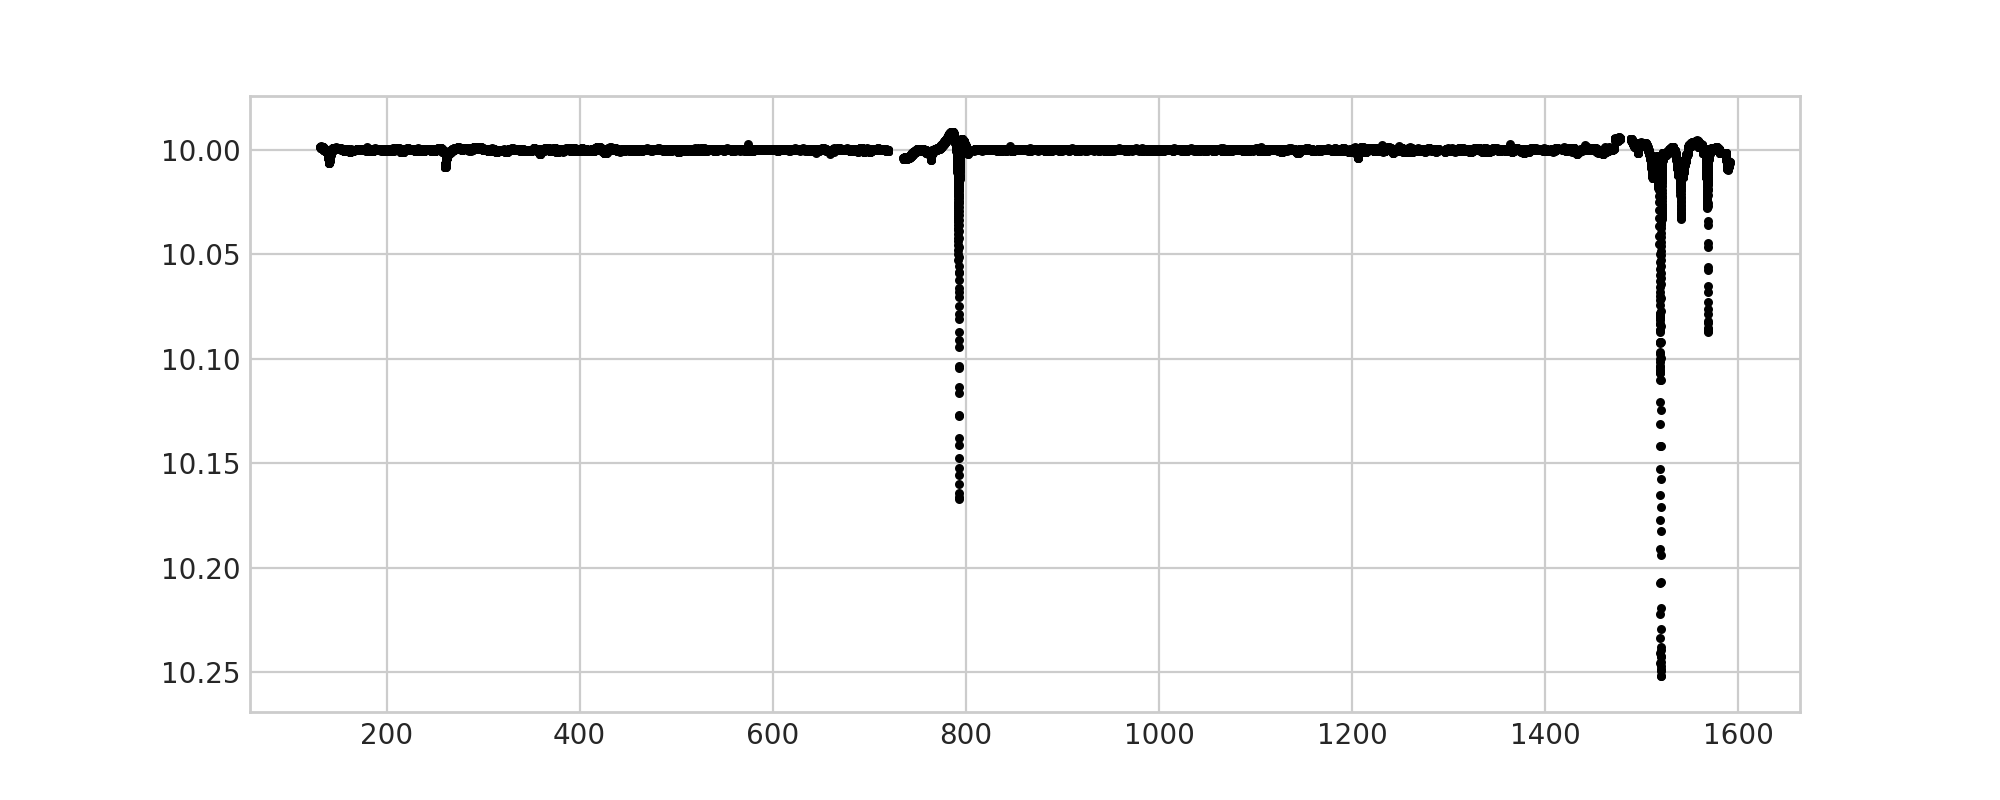

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.scatter(lc.time, -2.5*np.log10(lc.flux)+10, c="black", s=5)
ax.invert_yaxis()

### Function to get the Kepler data

Let's make a function to get the Kepler light curve:

In [10]:
def get_kepler_lightcurve():
    target = 'KIC 8462852'
    lc = search_lightcurvefile(target, quarter=1).download().PDCSAP_FLUX.normalize()
    for q in range(2,18):
        lc = lc.append(search_lightcurvefile(target, quarter=q).download().PDCSAP_FLUX.normalize())
        
    return lc

In [11]:
kepler_lc = get_kepler_lightcurve()

In [12]:
kepler_lc = kepler_lc.remove_nans()

## Load Kepler light curve from file:

In [5]:
kepler = np.loadtxt("notebooks/boyajians_star_kepler_normalized.dat")

In [6]:
kepler_lc = lightkurve.LightCurve(time=kepler[:,0], flux = kepler[:,1])

In [7]:
kepler_lc = kepler_lc.remove_nans()

## Add a period of time in front and at the end of the light curve

In [8]:
add_to_end = kepler_lc[:kepler_lc.time.searchsorted(kepler_lc.time[0]+500)]
add_to_end.time = add_to_end.time - add_to_end.time[0] + kepler_lc.time[-1]

add_to_start = kepler_lc[kepler_lc.time.searchsorted(kepler_lc.time[-1]-500):]
tdiff = add_to_start.time[-1] - kepler_lc.time[0]
add_to_start.time = add_to_start.time - tdiff
#add_to_start.time = add_to_start.time - add_to_start.time[-1] - kepler_lc.time[0]

In [9]:
kepler_lc = add_to_start.append(kepler_lc)

In [10]:
kepler_lc = kepler_lc.append(add_to_end)

In [11]:
kepler_lc.time

array([-368.47791405, -368.45748134, -368.43704862, ..., 2090.95203095,
       2090.97246409, 2090.99289734])

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.scatter(kepler_lc.time, kepler_lc.flux, c="black", s=5)
#ax.invert_yaxis()

## ZTF Cadences

Kyle made a pickle file with some ZTF cadence information:

In [13]:
datadir = "/epyc/data/boyajian/"

pickle_file = "sample_mjds_2.pkl"

In [14]:
ztf_cadence = pd.read_pickle(datadir + pickle_file)

In [15]:
ztf_cadence.head()

mjd_g  \
0  [58204.201331, 58206.1338889, 58450.4353819, 5...   
1  [58208.4476505, 58208.4842824, 58234.3558912, ...   
2  [58598.42826391111, 58598.42871531111, 58246.3...   
3  [58205.4712847, 58246.3551505, 58728.162881911...   
4  [58599.37923613333, 58235.417419, 58274.377963...   

                                               mag_g  \
0  [18.049786, 17.98969, 17.893917, 17.893661, 17...   
1  [16.587982, 16.418648, 16.603691, 16.678661, 1...   
2  [20.503447, 20.104498, 20.468098, 20.198317, 2...   
3  [19.52711, 19.600018, 19.734375, 19.756207, 19...   
4  [20.6547, 19.874813, 20.611324, 20.21209, 20.3...   

                                            magerr_g  \
0  [0.043785494, 0.042514425, 0.04061343, 0.04060...   
1  [0.027895203, 0.027219111, 0.02796397, 0.02830...   
2  [0.1468122, 0.12067488, 0.120341174, 0.1270227...   
3  [0.07429419, 0.07745236, 0.097713016, 0.084637...   
4  [0.14792758, 0.09857254, 0.13027763, 0.1135262...   

                                               mjd_r  \
0  [58475.45729171111, 58450.3772454, 58475.45774...   
1  [58502.56362271111, 58502.56866901111, 58502.5...   
2  [58694.26076391111, 58723.21578701111, 58217.4...   
3  [58694.26076391111, 58723.21578701111, 58666.3...   
4  [58700.21489581111, 58686.27434031111, 58700.2...   

                                               mag_r  \
0  [17.445889, 17.433268, 17.45091, 17.46019, 17....   
1  [15.69869, 15.667656, 15.66051, 15.677812, 15....   
2  [19.5084, 19.513474, 19.416594, 19.455902, 19....   
3  [18.070387, 18.075138, 18.075306, 18.28212, 18...   
4  [19.047123, 19.245966, 19.162663, 19.18438, 19...   

                                            magerr_r  
0  [0.029131362, 0.029901987, 0.029236319, 0.0294...  
1  [0.012726132, 0.012664719, 0.012650874, 0.0148...  
2  [0.08006927, 0.08037927, 0.08319566, 0.0769301...  
3  [0.029745415, 0.029832937, 0.029836038, 0.0340...  
4  [0.06769094, 0.07629721, 0.07256523, 0.0735206...

Okay, so that's a dataframe where each row is a list of MJDs. How long is this dataframe?

In [16]:
len(ztf_cadence)

32789

Haha, cool, we have lots of cadence information to play with. Let's pick one at random:

In [17]:
np.random.seed(1000)

In [18]:
n_cadence = len(ztf_cadence)

In [19]:
idx = np.random.randint(0, n_cadence)
print(idx)

4695


In [20]:
def get_ztf_lightcurve(ztf_df, idx):
    """
    Get a dictionary with ZTF points in r and g bands out 
    of the cadence data frame
    
    Parameters
    ----------
    ztf_df : pd.DataFrame
        A DataFrame with the ZTF data, has columns `mjd_g`, `mag_g`, 
        `magerr_g`, `mjd_r`, `mag_r`, `magerr_r`
        
    idx: int
        An index in ztf_df.index to choose a particular light curve
        
    Returns
    -------
    ztf_lc : dict
        A dictionary with the data in a given row of the DataFrame
    """
    
    ztf_line = ztf_df.loc[idx]
    mjd_g = ztf_line[0]
    mag_g = ztf_line[1]
    magerr_g = ztf_line[2]
    g_idx = np.argsort(mjd_g)
    mjd_g = mjd_g[g_idx]
    mag_g = mag_g[g_idx]
    magerr_g = magerr_g[g_idx]
    
    mjd_r = ztf_line[3]
    mag_r = ztf_line[4]
    magerr_r = ztf_line[5]

    r_idx = np.argsort(mjd_r)
    mjd_r = mjd_r[r_idx]
    mag_r = mag_r[r_idx]
    magerr_r = magerr_r[r_idx]
    
    tseg_g = mjd_g.max() - mjd_g.min()
    tseg_r = mjd_r.max() - mjd_r.min()

    ztf_lc = {"mjd_g": mjd_g, "mag_g": mag_g, "magerr_g": magerr_g,
              "mjd_r": mjd_r, "mag_r": mag_r, "magerr_r": magerr_r,
              "tseg_g": tseg_g, "tseg_r": tseg_r,
              "ng": len(mjd_g), "nr": len(mjd_r), 
              "zero_g": mjd_g[0], "zero_r":mjd_r[0]}
    
    return ztf_lc

In [21]:
ztf_lc = get_ztf_lightcurve(ztf_cadence, idx)

In [22]:
ztf_lc["mjd_g"]

array([58202.30657411, 58202.30752311, 58202.3202894 , 58202.32253471,
       58202.32303241, 58202.34365741, 58202.34765051, 58202.3484259 ,
       58202.36528931, 58202.3660417 , 58202.36766201, 58202.3705324 ,
       58203.36204861, 58203.36871531, 58203.38998841, 58203.39092591,
       58203.41055551, 58204.30612271, 58204.32546301, 58204.34760421,
       58204.35298611, 58204.37420141, 58204.37607641, 58204.37748841,
       58204.39862271, 58204.41739581, 58205.29771991, 58205.32548611,
       58205.33863421, 58205.3509259 , 58205.36042821, 58205.37143521,
       58205.37618051, 58205.3769213 , 58205.3797222 , 58205.38172451,
       58205.39694441, 58205.4159144 , 58205.45837961, 58205.48208331,
       58206.27326391, 58206.30195601, 58206.32442131, 58206.32643521,
       58206.35291671, 58206.35432871, 58206.35524301, 58206.35667821,
       58206.39197921, 58206.39391201, 58206.41677081, 58206.43549771,
       58207.30568291, 58207.30725691, 58207.32320601, 58207.32803241,
      

In [23]:
ztf_lc["ng"]

723

Ok, cool. 

How long is this light curve in days?

In [24]:
print("Total length in g band: " + str(ztf_lc["tseg_g"]))
print("Total length in r band: " + str(ztf_lc["tseg_r"]))

Total length in g band: 531.9119906999986
Total length in r band: 535.9404398999977


Let's also write a function to read a ZTF light curve from a CSV file:

In [25]:
ztf_boyajian = np.zeros((len(ztf_lc["mjd_g"]), 3))

kepler_time_normalized = kepler_lc.time - kepler_lc.time[0]

for i in range(ztf_lc["ng"]):
    t = ztf_lc["mjd_g"][i] - ztf_lc["zero_g"]
    f = ztf_lc["mag_g"][i]
    fe = ztf_lc["magerr_g"][i]
    
    idx = kepler_time_normalized.searchsorted(t)
    #print(idx)
    
    ztf_boyajian[i,0] = kepler_lc.time[idx]
    ztf_boyajian[i,1] = kepler_lc.flux[idx]
    ztf_boyajian[i,2] = kepler_lc.flux_err[idx]

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))

sns.rugplot(ztf_lc["mjd_g"] - ztf_lc["zero_g"], lw=3, color="red", ax=ax)
ax.scatter(kepler_time_normalized, kepler_lc.flux, s=5, c="black")
ax.scatter(ztf_boyajian[:,0] - kepler_lc.time[0], ztf_boyajian[:,1], s=5, c="red")

Let's make a function to automate these simulations:

In [164]:
def simulate_boyajian(kepler_lc, ztf_lc, start_point=None, 
                      use_mean=True):
    """
    Simulate Boyajian's star's Kepler light curve in a ZTF cadence.
    
    This function uses the (normalized) Kepler light curve of 
    Boyajian's star, and observed time stamps of ZTF observations, to 
    simulate what the Kepler light curve would look like in a ZTF 
    cadence. Right now, it only simulates fluxes, not flux errors. 
    
    Parameters
    -----------
    kepler_lc : lightkurve.LightCurve object
        A Lightcurve object with the Kepler light curve.
        
    ztf_lc : dict
        A dictionary with data from a ZTF light curve, generated by 
        `get_ztf_lightcurve` function.
        
    start_point : {None, "random"}, default None
        If None, start at the beginning of the Kepler light curve. 
        If "random", start somewhere randomly in the Kepler light curve.
        
    use_mean : boolean
        If True, scale the Kepler flux for Boyajian's star using the 
        mean and errors of the real ZTF light curve.

    Returns:
    --------
    ztf_boyajian : lightkurve.LightCurve object
        A LightCurve object with the flux from Boyajian's star as 
        measured by Kepler, but using data points derived from a real 
        ZTF cadence.
    """
    # make an empty array for the output light curve
    ztf_boyajian_g = np.zeros((ztf_lc["ng"], 3))
    ztf_boyajian_r = np.zeros((ztf_lc["nr"], 3))

    # normalize time array of the Kepler and ZTF data to zero
    kepler_time_normalized = kepler_lc.time - kepler_lc.time[0]
    
    mean_ztf_mag_g = np.mean(ztf_lc["mag_g"])
    #print("mean ZTF magnitude in g-band: " + str(mean_ztf_mag_g))

    mean_ztf_mag_r = np.mean(ztf_lc["mag_r"])
    #print("mean ZTF magnitude in r-band: " + str(mean_ztf_mag_r))

    if start_point is None:
        ztf_time_g_normalized = ztf_lc["mjd_g"] - ztf_lc["zero_g"]
        ztf_time_r_normalized = ztf_lc["mjd_r"] - ztf_lc["zero_r"]

    elif start_point == "random":
        # calculate the length of the ZTF light curve
        ztf_tseg = np.max([ztf_lc["tseg_g"], ztf_lc["tseg_r"]])
        random_point = np.random.uniform(0, kepler_time_normalized[-1] - ztf_tseg)
        ztf_time_g_normalized = ztf_lc["mjd_g"] - ztf_lc['zero_g'] + random_point
        ztf_time_r_normalized = ztf_lc["mjd_r"] - ztf_lc['zero_r'] + random_point

    else:
        raise ValueError("start_point must be either None or 'random'")
     
    
    magerr_g_mask = (ztf_lc["magerr_g"] <= 0)
    ztf_lc["magerr_g"][magerr_g_mask] = np.mean(ztf_lc["magerr_g"])

    magerr_r_mask = (ztf_lc["magerr_r"] <= 0)
    ztf_lc["magerr_r"][magerr_r_mask] = np.mean(ztf_lc["magerr_r"])


    # let's assign points for the g-band
    for i in range(ztf_lc["ng"]):
        t = ztf_time_g_normalized[i]
        #f = ztf_lc["mag_g"][i]
        fe = ztf_lc["magerr_g"][i]
                
        idx = kepler_time_normalized.searchsorted(t)
        
        # time stamps and flux come from the Kepler data
        ztf_boyajian_g[i,0] = kepler_lc.time[idx]
        
        if use_mean: 
            ztf_boyajian_g[i,1] = -2.5*np.log10(kepler_lc.flux[idx]) + np.random.normal(mean_ztf_mag_g, fe)
        else:
            ztf_boyajian_g[i,1] = kepler_lc.flux[idx] 
    
        # flux_err comes from ZTF data
        ztf_boyajian_g[i,2] = fe
    
    meta_g = {"ztf_mean_mag": mean_ztf_mag_g}
    ztf_boyajian_g = lightkurve.LightCurve(time=ztf_boyajian_g[:,0], 
                                           flux=ztf_boyajian_g[:,1], 
                                           flux_err=ztf_boyajian_g[:,2],
                                           meta=meta_g)

    # same for the r-band:
    for i in range(ztf_lc["nr"]):
        t = ztf_time_r_normalized[i]
        fe = ztf_lc["magerr_r"][i]
                
        idx = kepler_time_normalized.searchsorted(t)
        
        # time stamps and flux come from the Kepler data
        ztf_boyajian_r[i,0] = kepler_lc.time[idx]
        
        if use_mean: 
            ztf_boyajian_r[i,1] = -2.5*np.log10(kepler_lc.flux[idx]) + np.random.normal(mean_ztf_mag_r, fe)
        else:
            ztf_boyajian_r[i,1] = kepler_lc.flux[idx]
    
        # flux_err comes from ZTF data
        ztf_boyajian_r[i,2] = fe
    
    meta_r = {"ztf_mean_mag": mean_ztf_mag_r}

    ztf_boyajian_r = lightkurve.LightCurve(time=ztf_boyajian_r[:,0], 
                                           flux=ztf_boyajian_r[:,1], 
                                           flux_err=ztf_boyajian_r[:,2],
                                           meta=meta_r)


    return ztf_boyajian_g, ztf_boyajian_r

Let's try this, too:

In [165]:
ztf_boyajian_g, ztf_boyajian_r = simulate_boyajian(kepler_lc, ztf_lc, 
                                                   start_point="random")

In [161]:
ztf_boyajian_r

In [156]:
ztf_boyajian_g

Now let's make a function that plots the Kepler light curve and overplots the 
ZTF cadence version:

In [157]:
def plot_cadence(kepler_lc, ztf_boyajian_r=None, ztf_boyajian_g=None, band="both", ax=None):
    """
    Plot the Kepler light curve and overplot the version generated 
    using a ZTF cadence for comparison and diagnostics.
    
    Parameters
    ----------
    kepler_lc : lightkurve.LightCurve object
        A Lightcurve object with the Kepler light curve.
        
    ztf_boyajian_r, ztf_boyajian_g : lightkurve.LightCurve object
        A LightCurve object with the flux from Boyajian's star as 
        measured by Kepler, but using data points derived from a real 
        ZTF cadence in either r- or g-band.

    band : str, {"r", "g", "both"}
        Determines which band to plot. Options are to plot r-band only, 
        g-band only or both.

    ax : matplotlib.pyplot.Axes object
        An Axes object to plot into
        
    """
    
    r_colour = sns.color_palette("colorblind", n_colors=7)[1]
    g_colour = sns.color_palette("colorblind", n_colors=7)[2]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10,5))
    
    ax.scatter(kepler_lc.time - kepler_lc.time[0], kepler_lc.flux, 
               s=5, c="black", label="Kepler light curve")

    if band == "r" or band == "both":
        assert ztf_boyajian_r is not None, "Need a Lightcurve object to plot r-band magnitudes!"

        sns.rugplot(ztf_boyajian_r.time - kepler_lc.time[0], lw=1, 
                color=r_colour, ax=ax)
        ax.scatter(ztf_boyajian_r.time - kepler_lc.time[0], 
               ztf_boyajian_r.flux-ztf_boyajian_r.meta["ztf_mean_mag"], 
               s=5, c=r_colour, label="simulated r-band points")
    
    if band == "g" or band == "both":
        assert ztf_boyajian_g is not None, "Need a Lightcurve object to plot g-band magnitudes!"

        sns.rugplot(ztf_boyajian_g.time - kepler_lc.time[0], lw=1, 
                color=g_colour, ax=ax)
        ax.scatter(ztf_boyajian_g.time - kepler_lc.time[0], 
               ztf_boyajian_g.flux-ztf_boyajian_g.meta["ztf_mean_mag"], 
               s=5, c=g_colour, label="simulated g-band points")
    
    ax.set_xlim(0, kepler_lc.time[-1]-kepler_lc.time[0])
    ax.legend()
    
    return ax

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


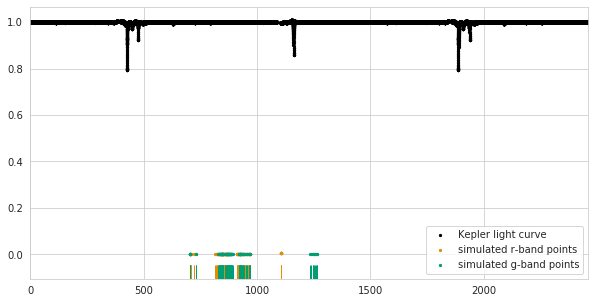

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

plot_cadence(kepler_lc, ztf_boyajian_r, ztf_boyajian_g, "both", ax=ax)

### More Light Curves

Let's do this for some other light curves:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

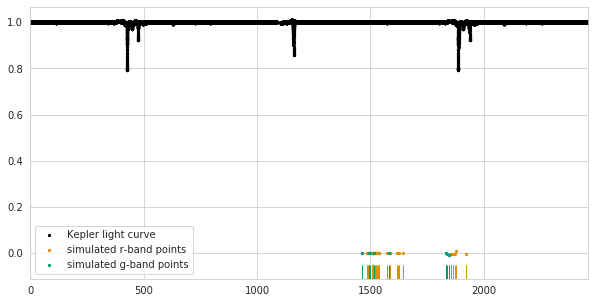

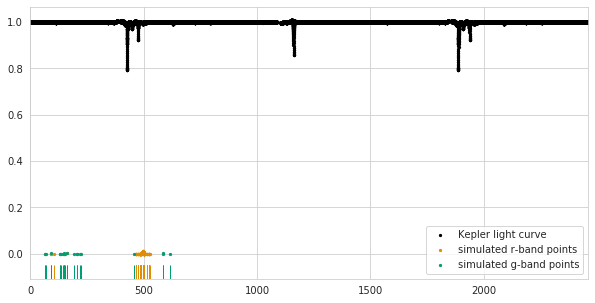

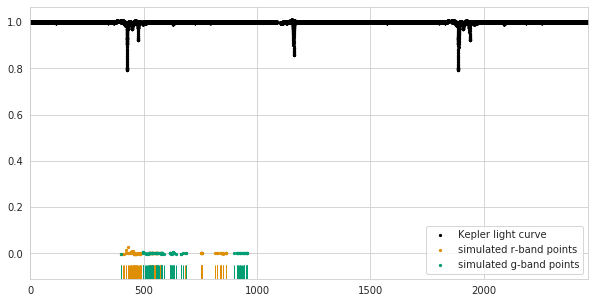

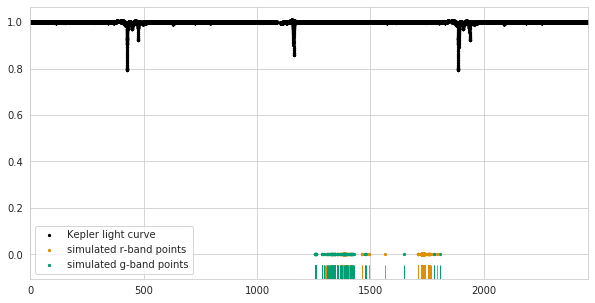

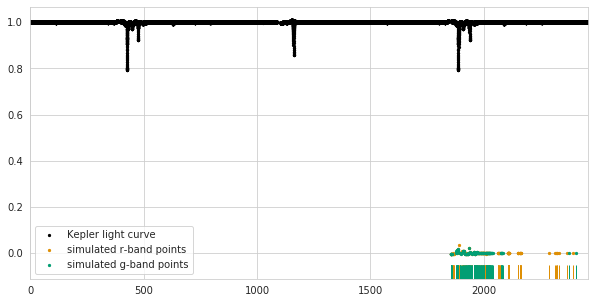

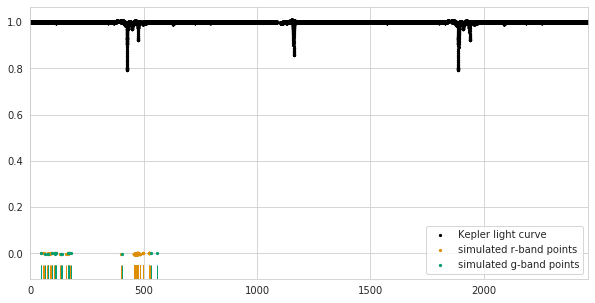

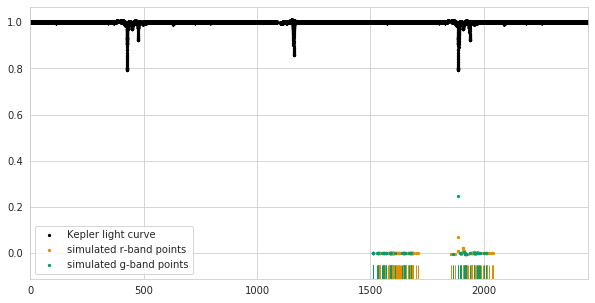

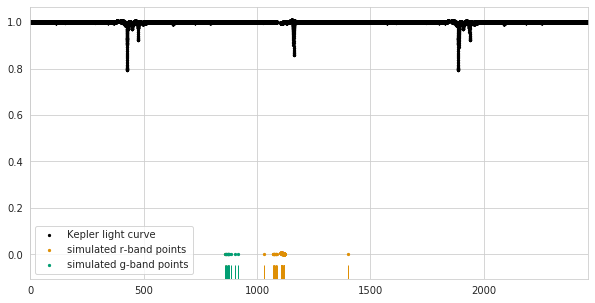

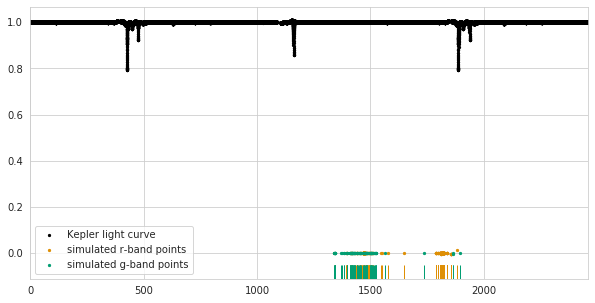

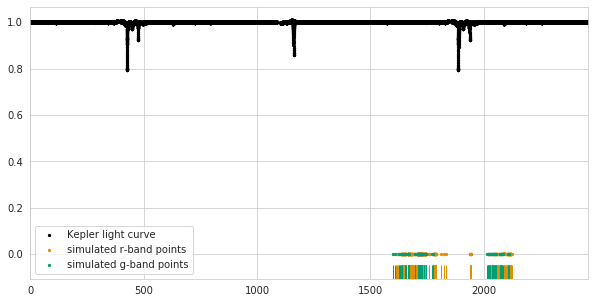

In [114]:
idx_set = np.random.choice(np.arange(0,len(ztf_cadence), step=1), replace=False, size=10)

for idx in idx_set:
    ztf_lc = get_ztf_lightcurve(ztf_cadence, idx)
    ztf_boyajian_g, ztf_boyajian_r = simulate_boyajian(kepler_lc, ztf_lc, 
                                                   start_point="random")
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    plot_cadence(kepler_lc, ztf_boyajian_r, ztf_boyajian_g, "both", ax=ax)

Okay, let's simulate some light curves doing this:

In [166]:
np.random.seed(100)

# number of simulations to run
nsims = 10000

# number of available cadences from 
# example light curves
ncadences = len(ztf_cadence)

# empty list for example light curves
ztf_boyajian_r_examples, ztf_boyajian_g_examples = [], []

for i in range(nsims):
    # randomly select a data file to simulate a cadence from
    df_idx = np.random.randint(0, ncadences-1)
    
    # get the ZTF light curve out of the DataFrame
    ztf_lc = get_ztf_lightcurve(ztf_cadence, df_idx)
    
    # simulate an example
    ztf_boyajian_g, ztf_boyajian_r = simulate_boyajian(kepler_lc, ztf_lc, 
                                                   start_point="random")

    # let's save this in a list
    ztf_boyajian_g_examples.append(ztf_boyajian_g)
    ztf_boyajian_r_examples.append(ztf_boyajian_r)
    

Let's plot some examples:

<IPython.core.display.Javascript object>


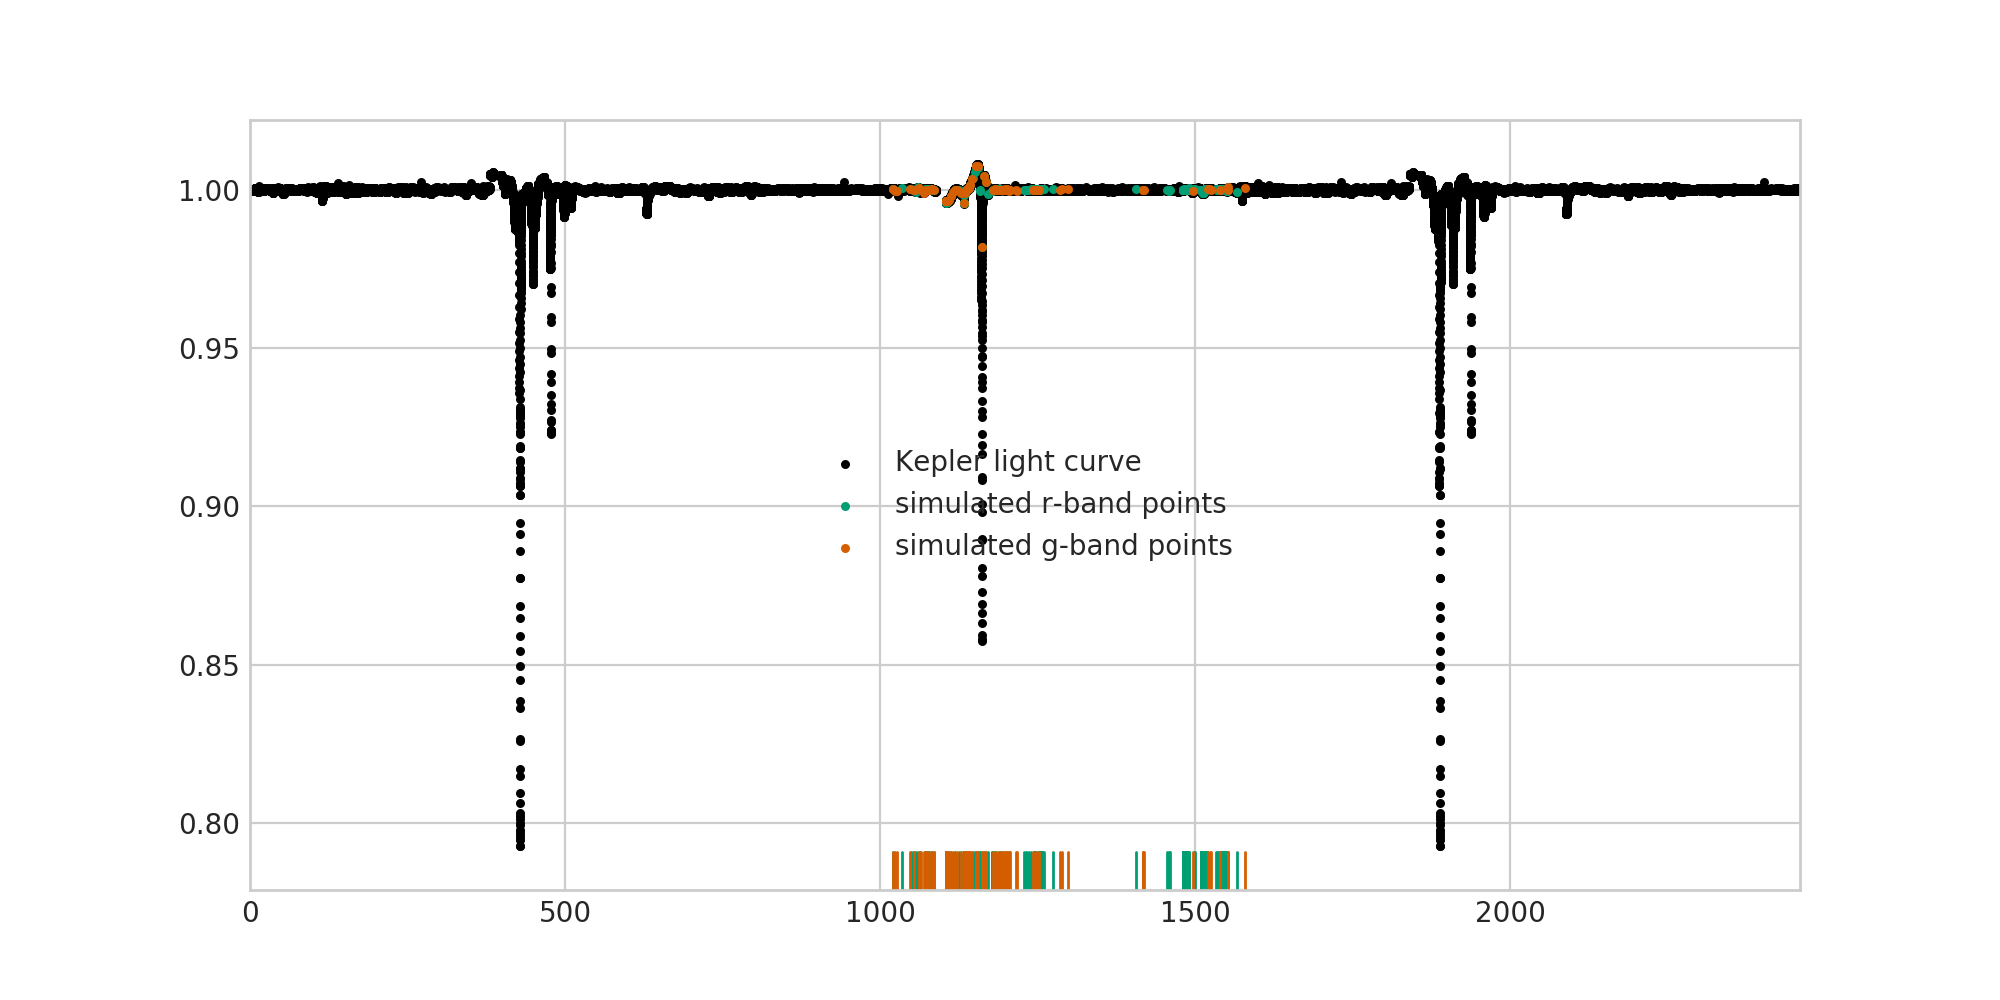

<IPython.core.display.Javascript object>


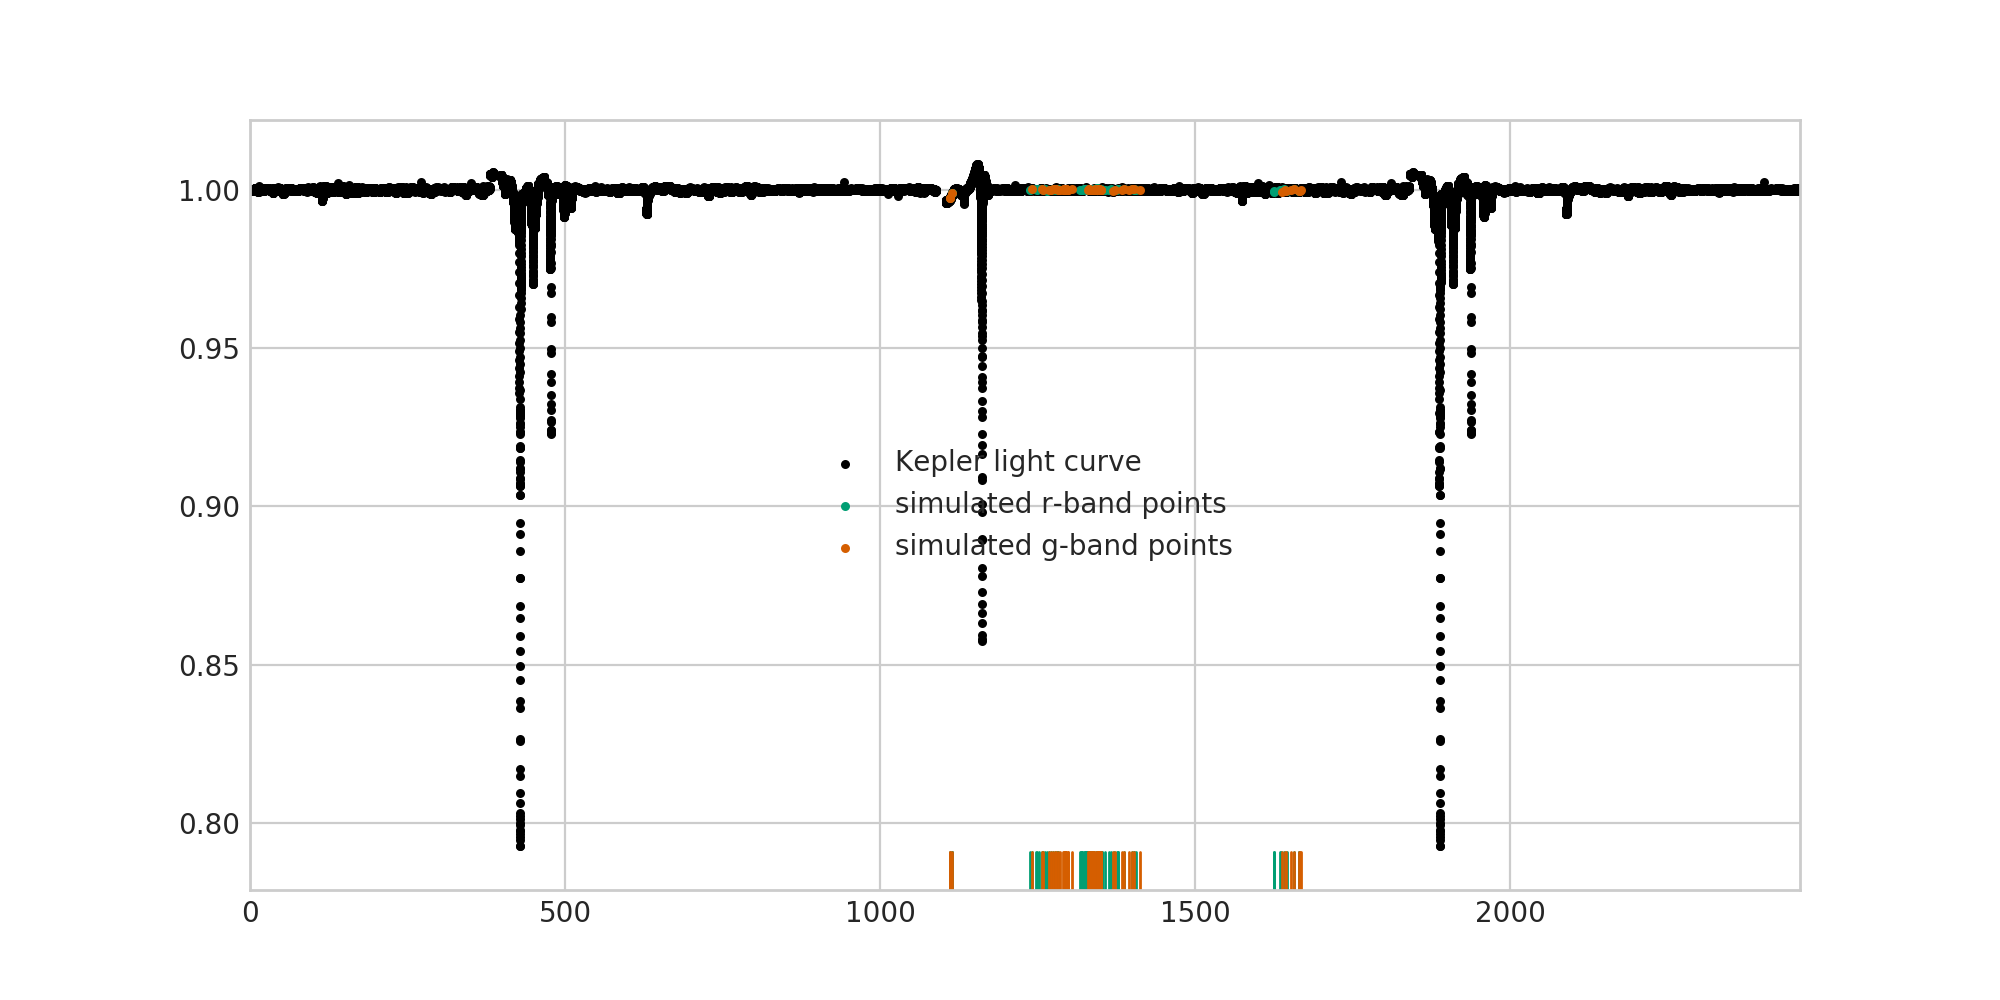

<IPython.core.display.Javascript object>


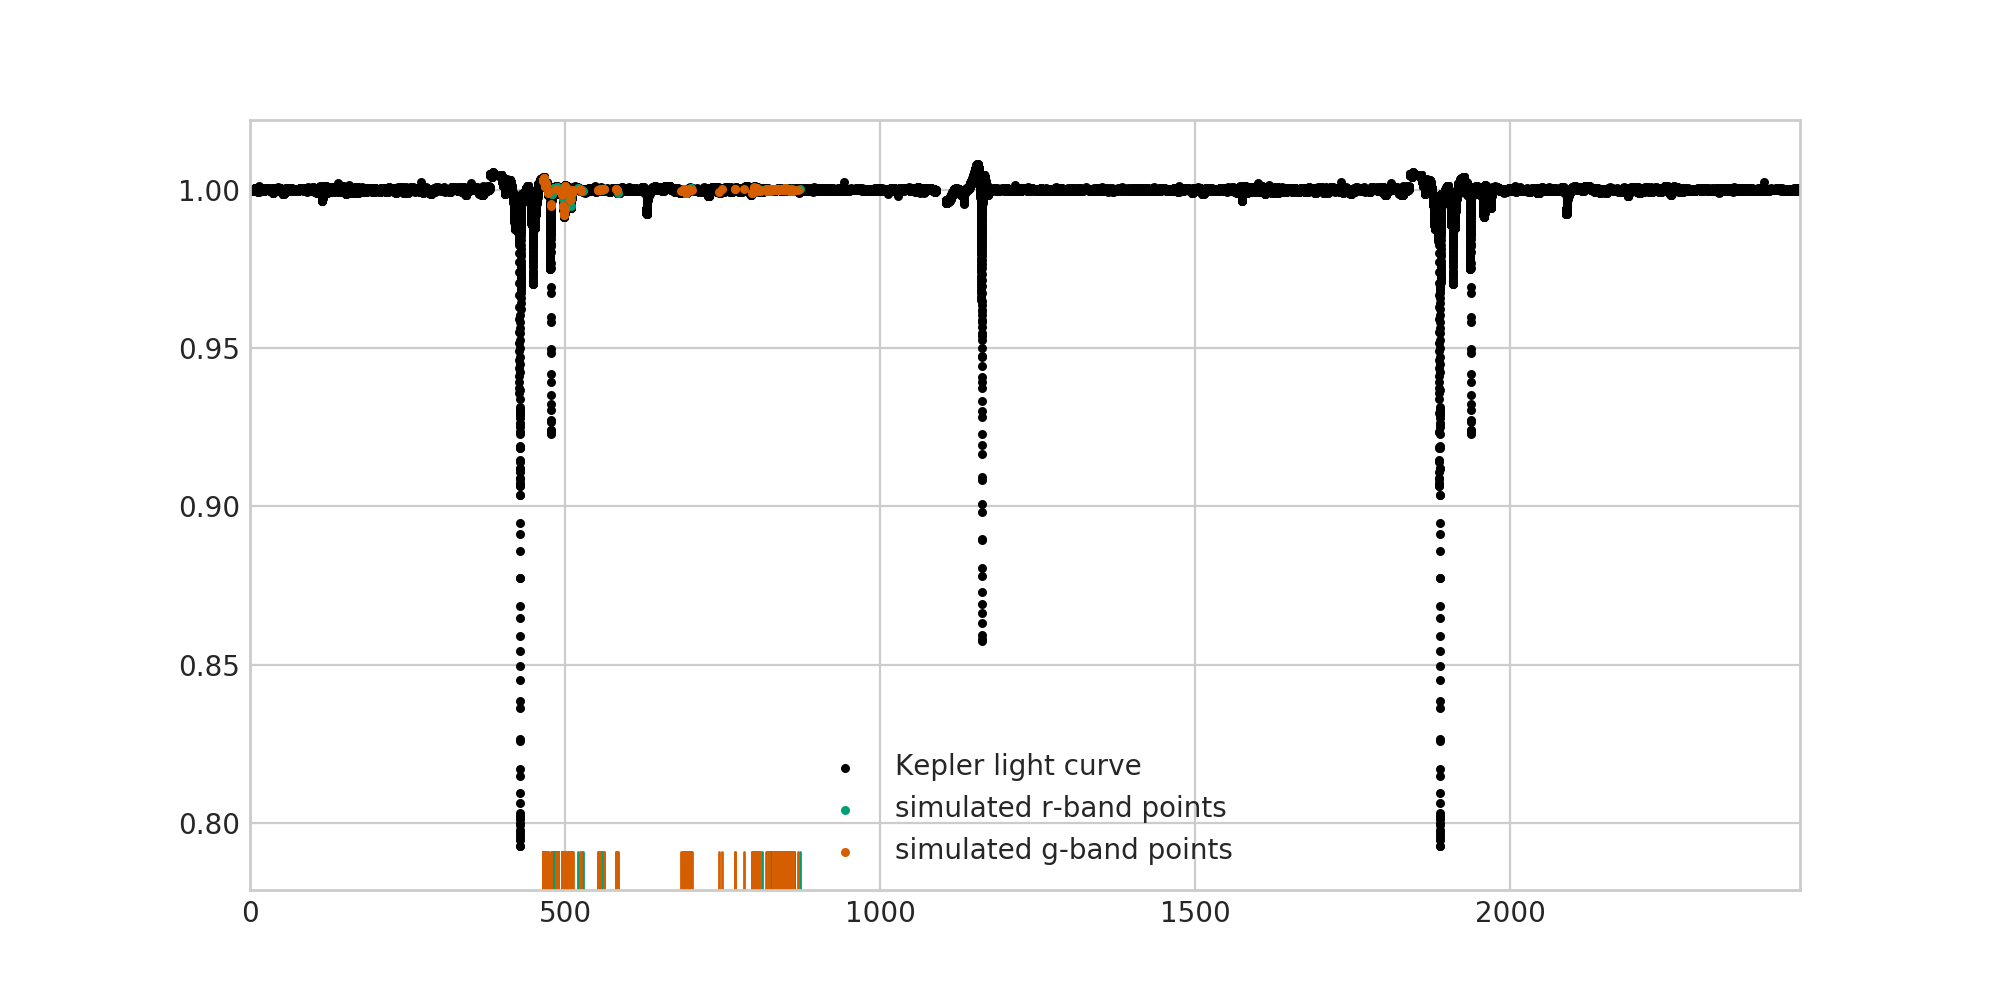

<IPython.core.display.Javascript object>


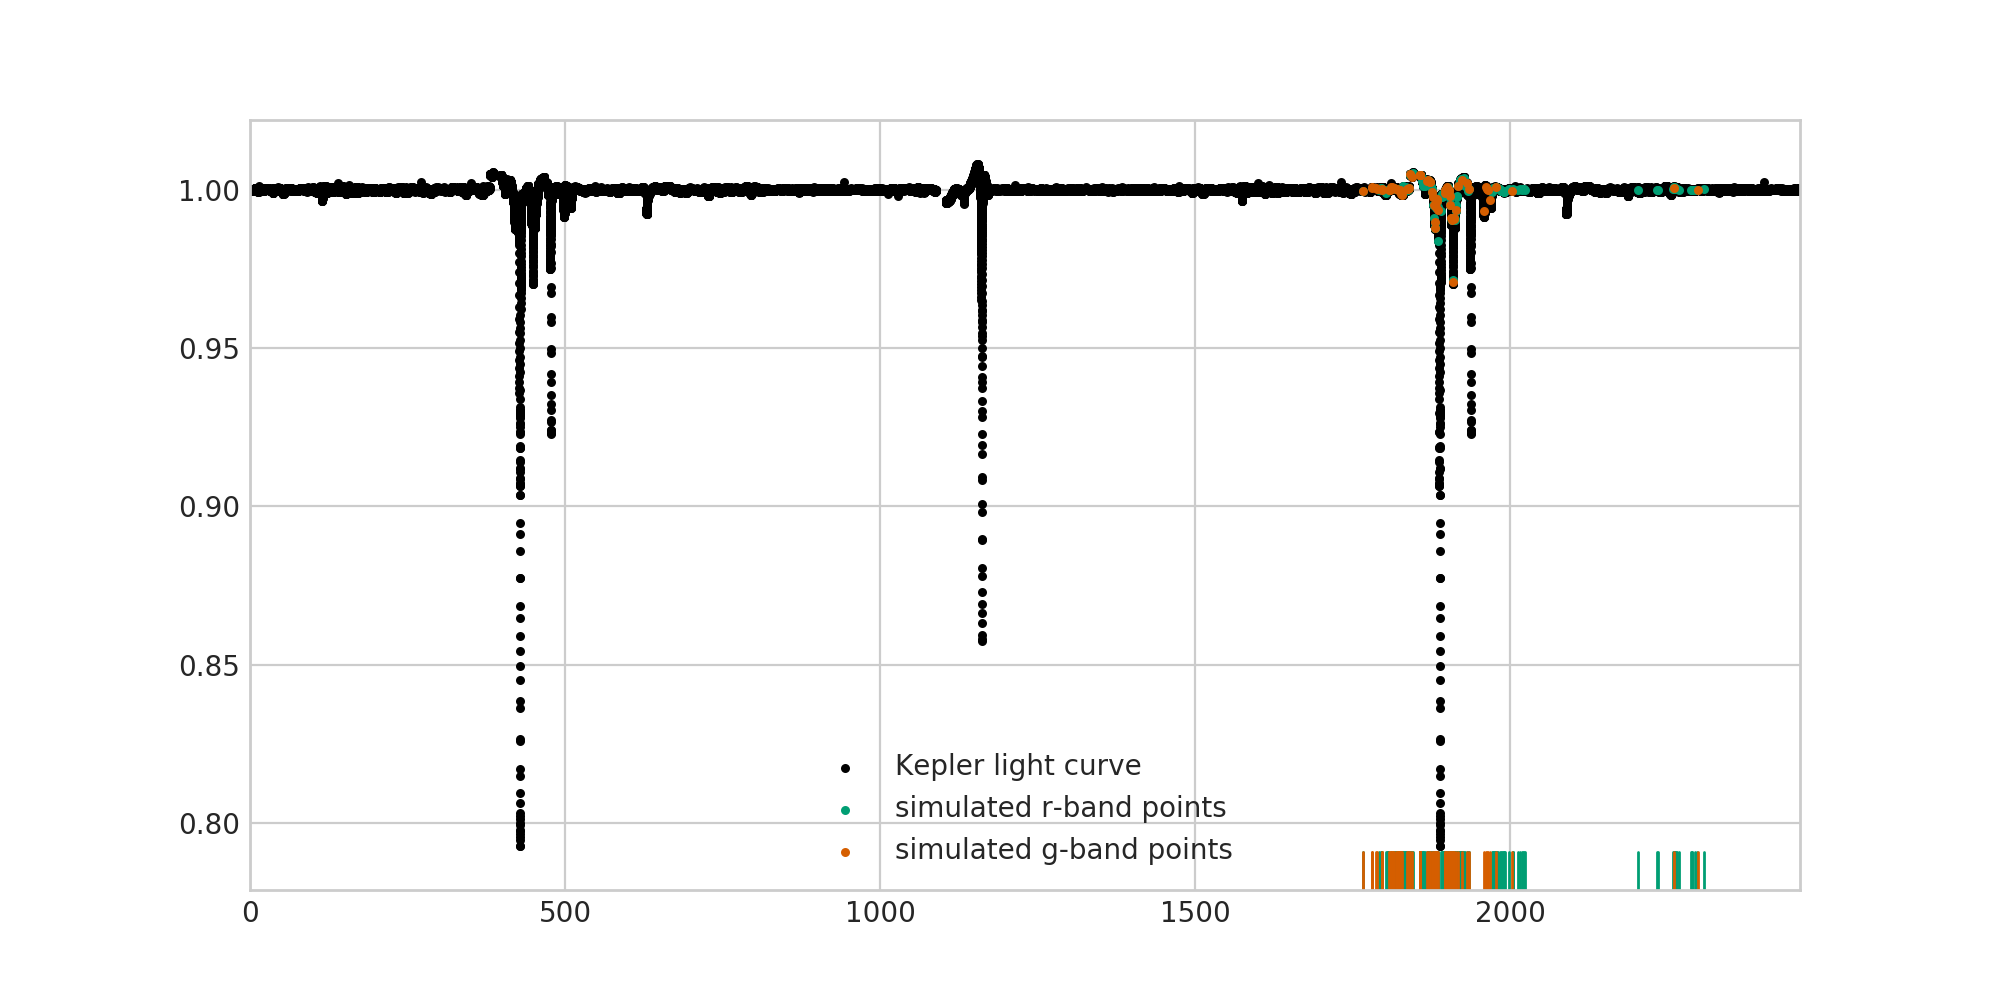

<IPython.core.display.Javascript object>


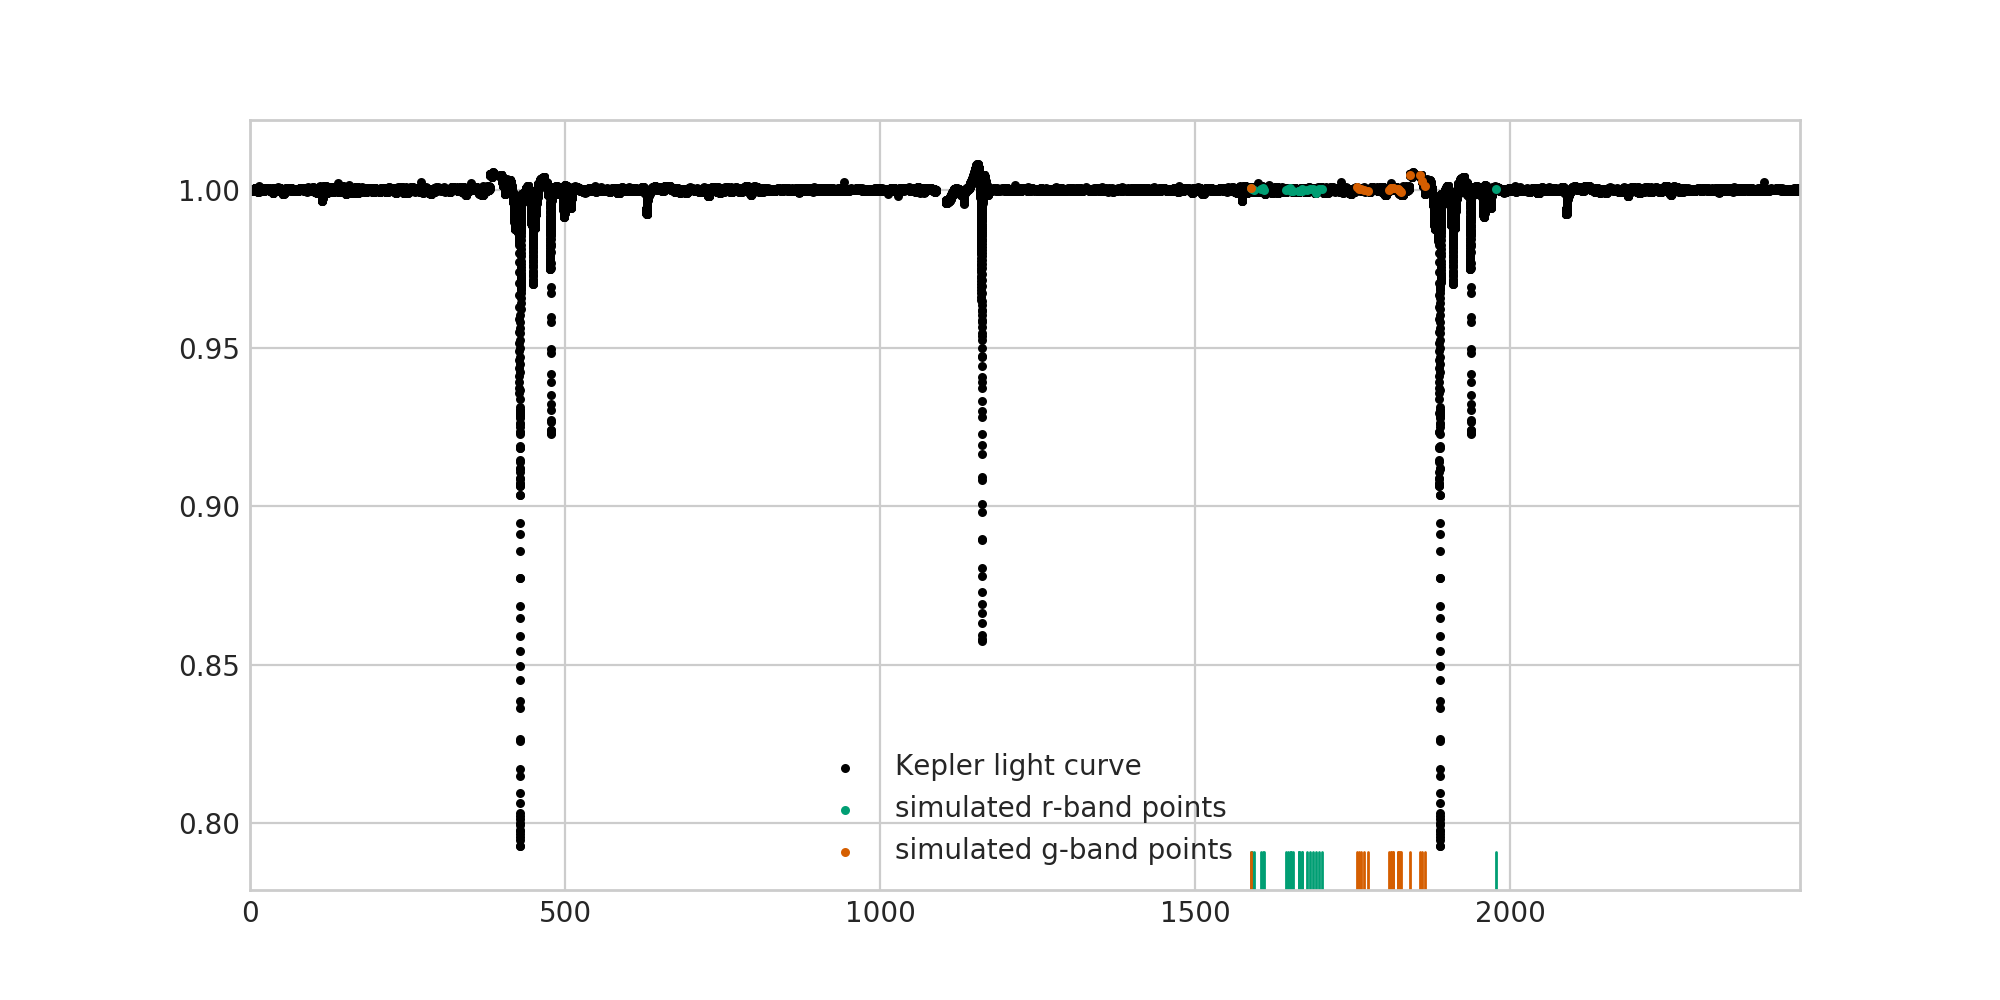

<IPython.core.display.Javascript object>


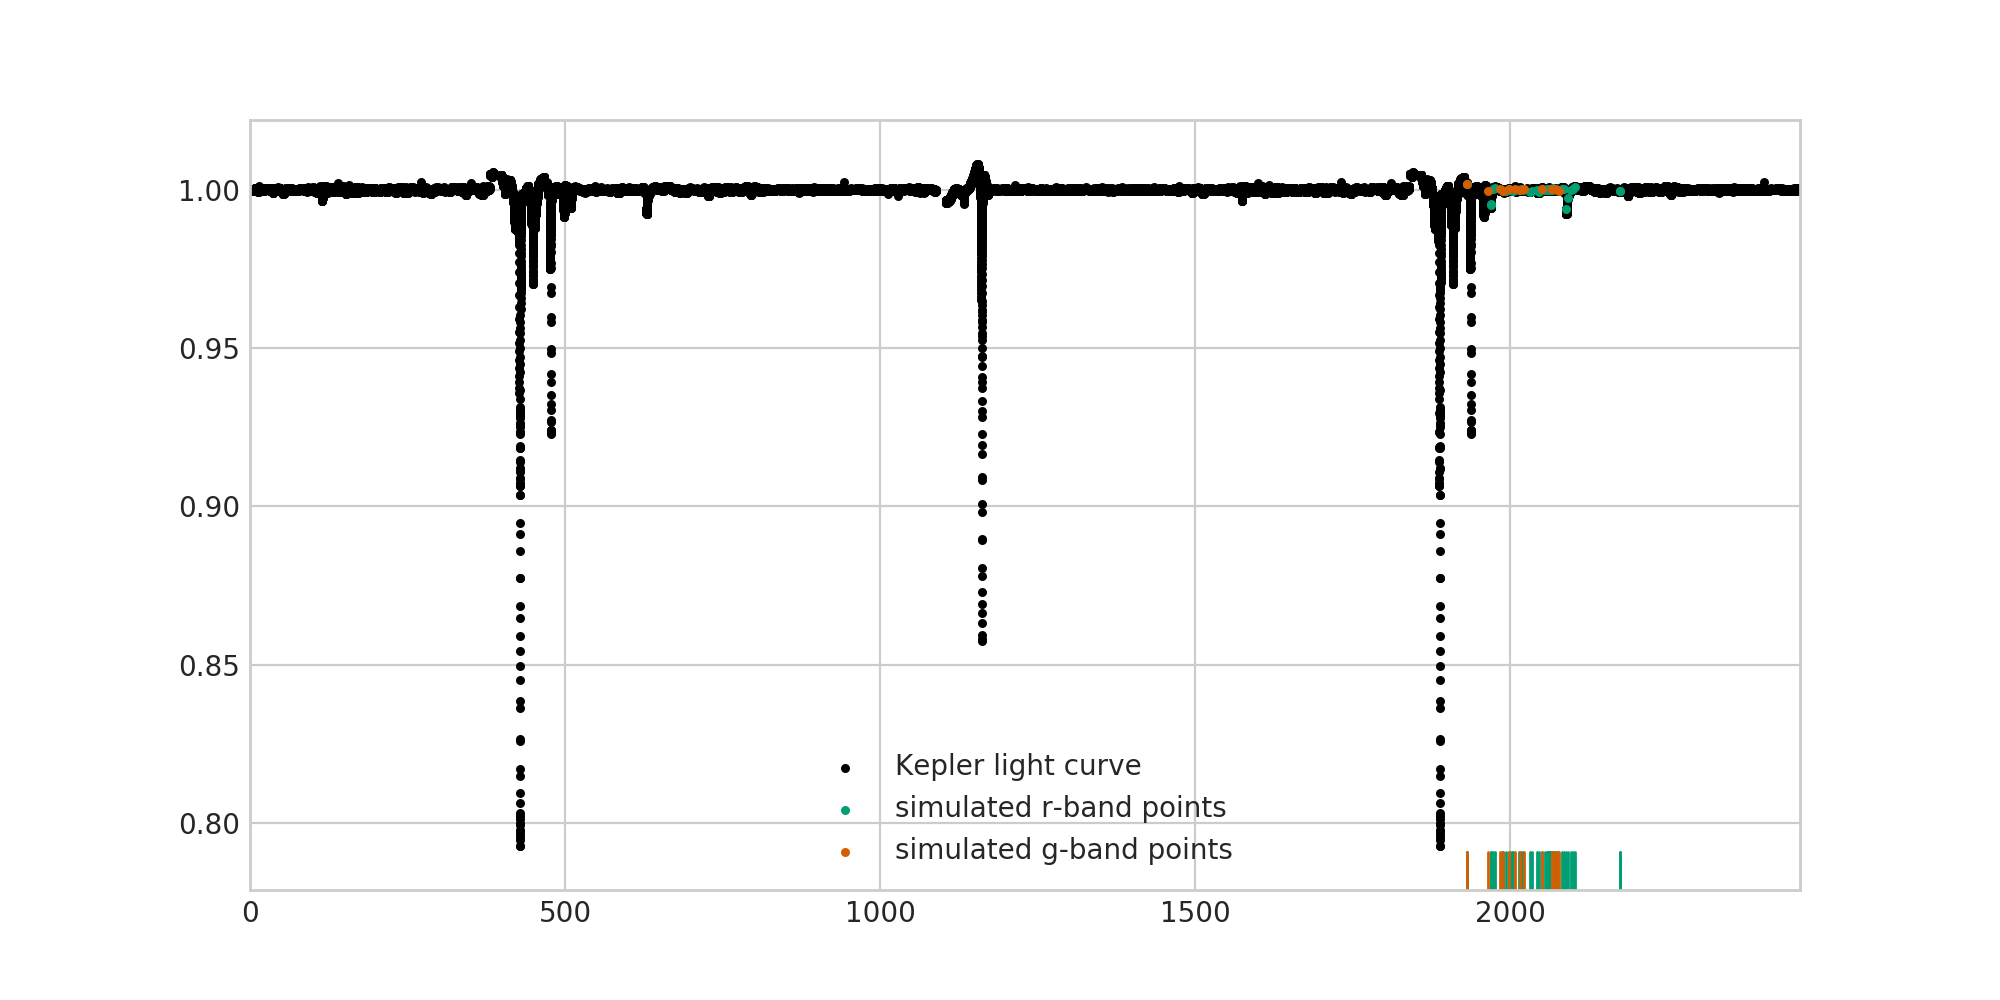

<IPython.core.display.Javascript object>


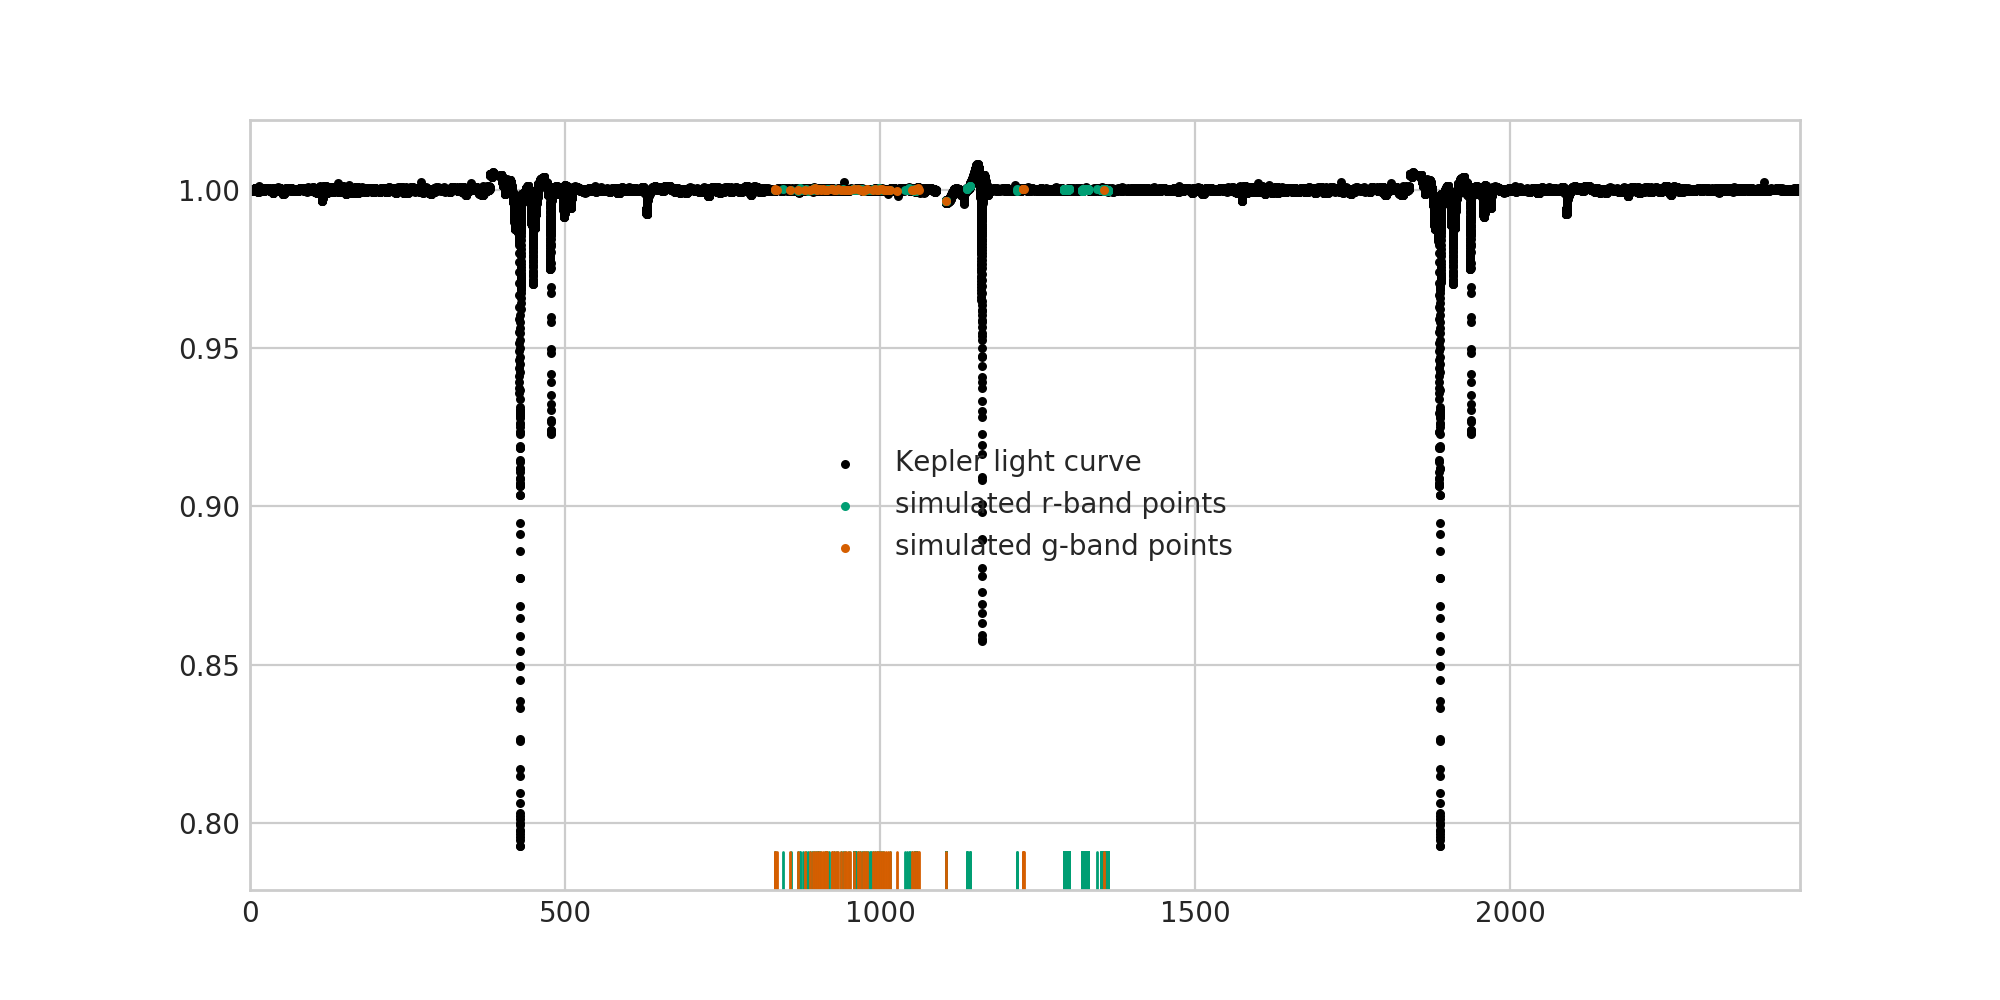

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


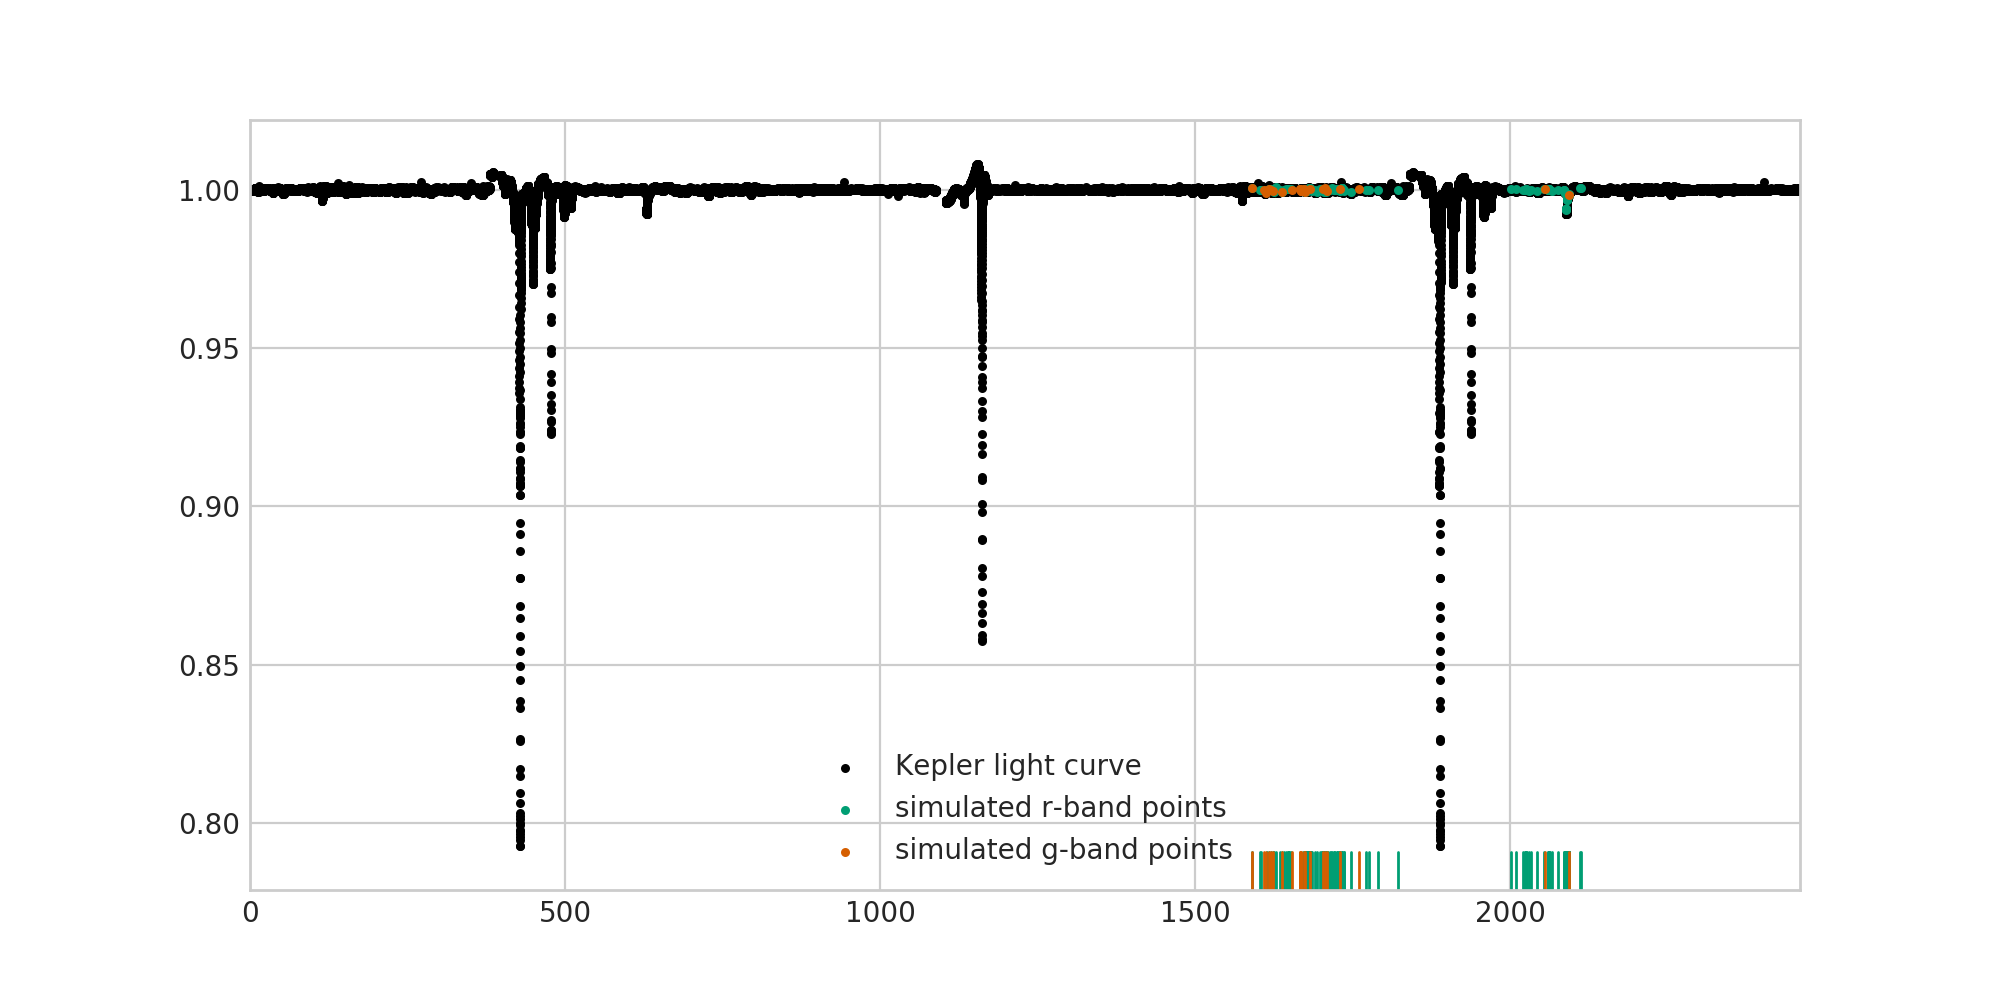

<IPython.core.display.Javascript object>


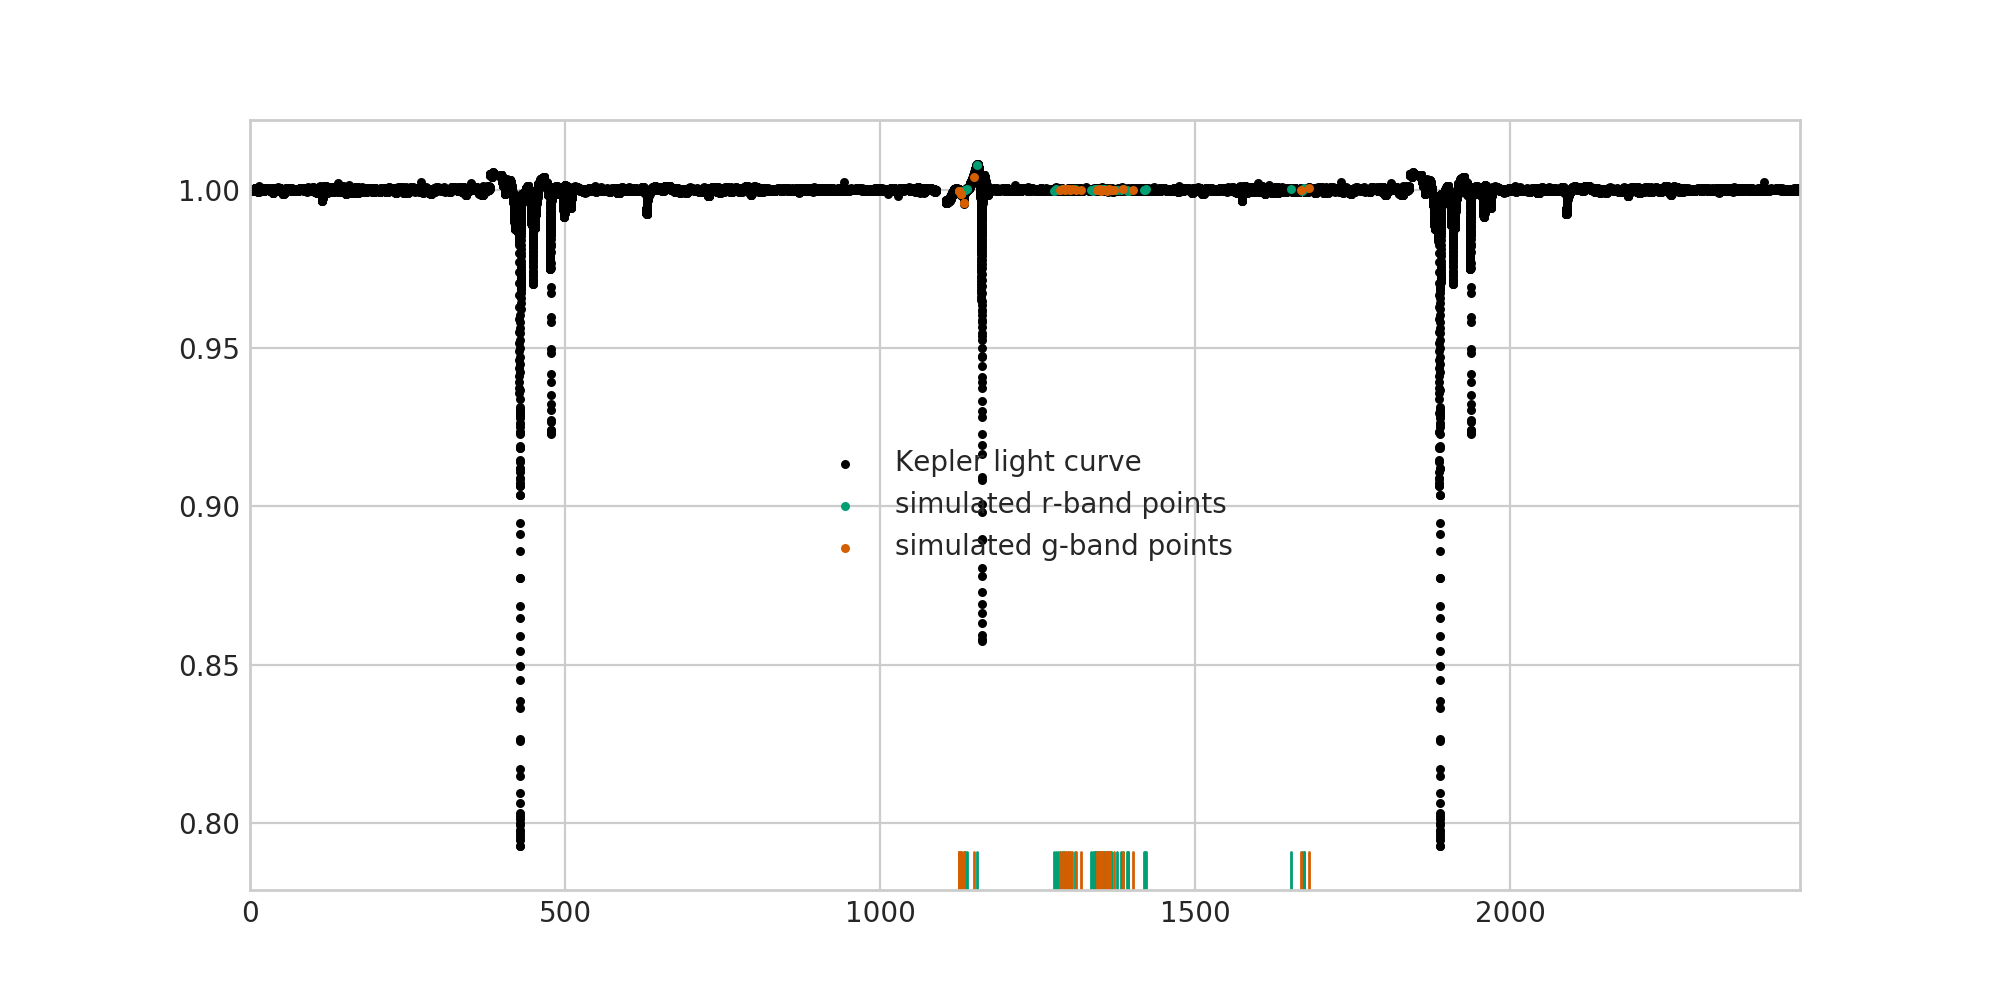

<IPython.core.display.Javascript object>


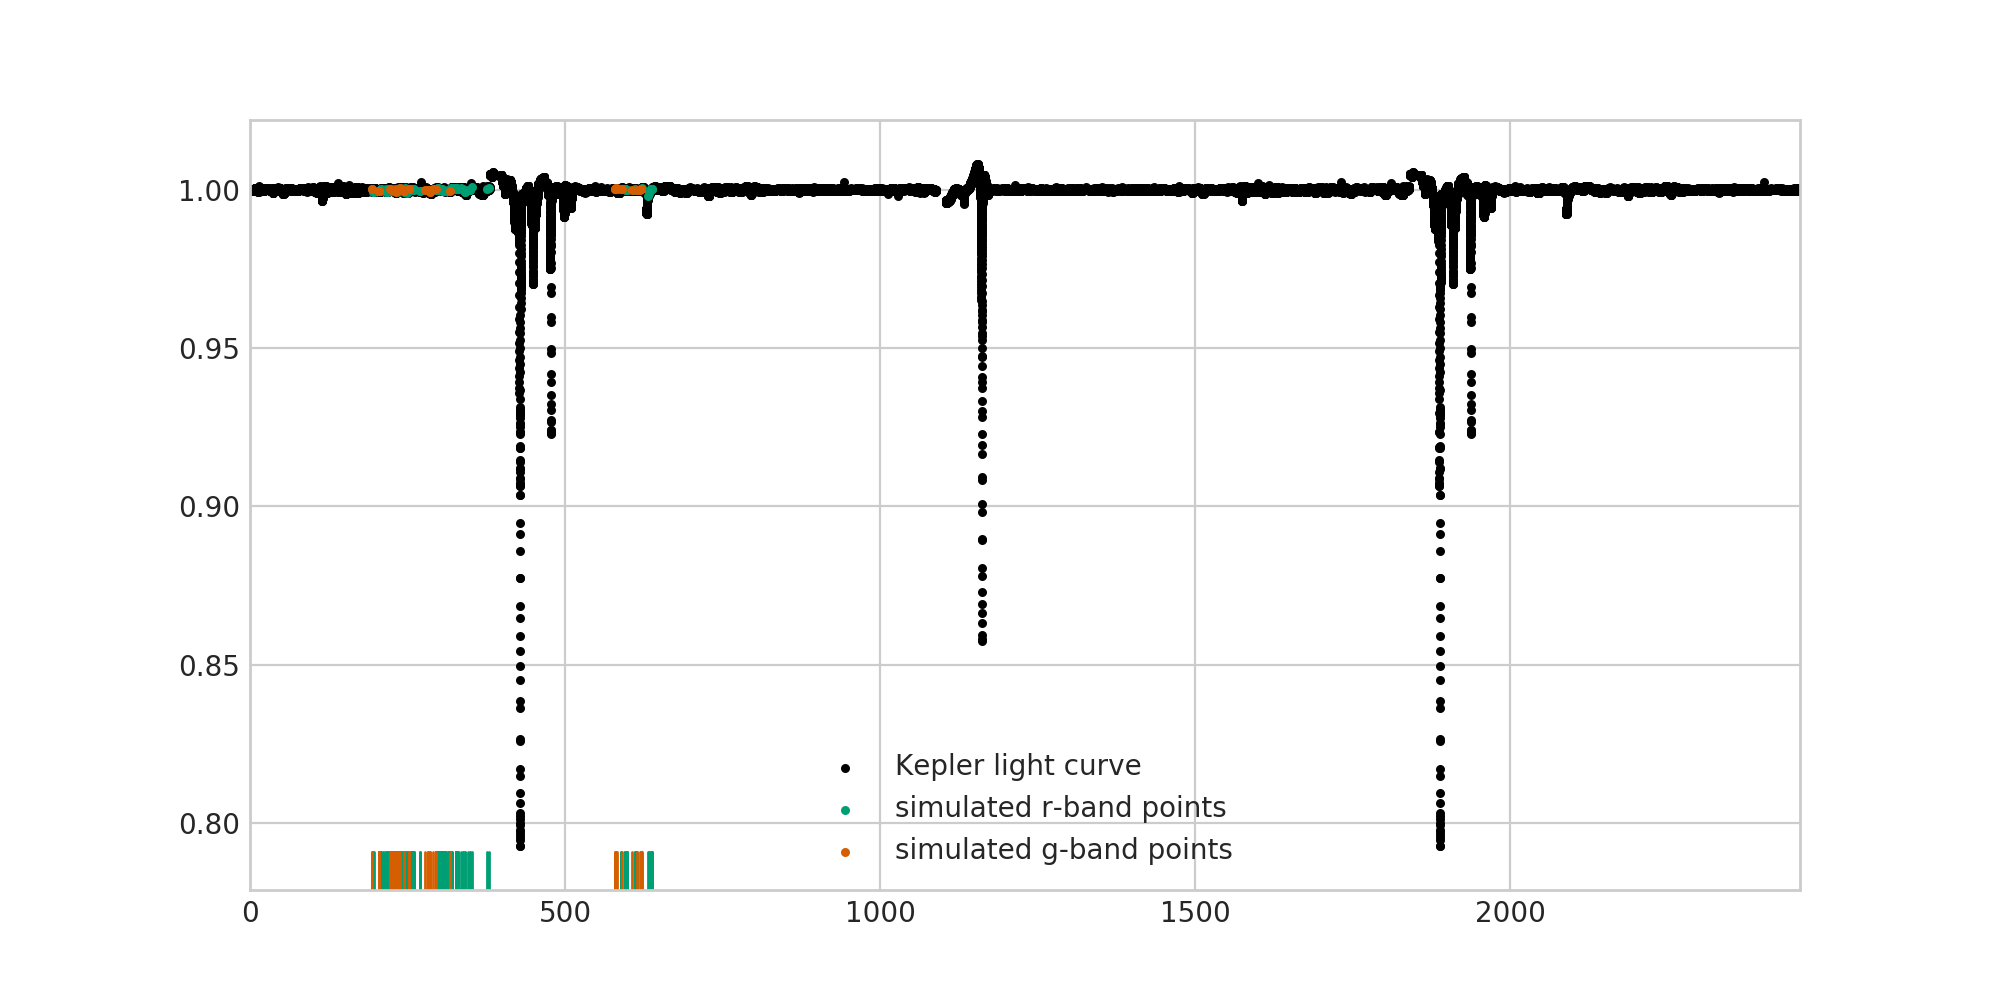

In [36]:
example_idx = np.random.choice(np.arange(nsims, dtype=int), replace=False, size=10)

for idx in example_idx:
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    plot_cadence(kepler_lc, ztf_boyajian_r_examples[idx], ztf_boyajian_g_examples[idx], "both", ax=ax)

Let's figure out how often in my light curves do I see a Boyajian star-like dip:

In [116]:
flare_present_r, flare_present_g = [], []

for example_lc_r, example_lc_g in zip(ztf_boyajian_r_examples, ztf_boyajian_g_examples):
    #print((example_lc_r.flux - example_lc_r.meta["ztf_mean_mag"]))
    b = np.any((example_lc_r.flux - example_lc_r.meta["ztf_mean_mag"]) < 0.8)
    flare_present_r.append(b)

In [117]:
len(ztf_boyajian_r_examples)

500

In [118]:
np.sum(flare_present_r)

500

In [64]:
ztf_boyajian_r_examples = np.array(ztf_boyajian_r_examples)
ztf_boyajian_g_examples = np.array(ztf_boyajian_g_examples)

KeyboardInterrupt: 

In [63]:
ztf_with_dips_r = ztf_boyajian_r_examples[flare_present_r]
ztf_with_dips_g = ztf_boyajian_g_examples[flare_present_r]

TypeError: list indices must be integers or slices, not list

In [ ]:
ztf_with_dips_npoints = np.zeros(len(ztf_with_dips_r))
for i,ztf_lc in enumerate(ztf_with_dips_r):
    ztf_with_dips_npoints[i] = len(ztf_lc.time)

In [ ]:
len(ztf_with_dips_npoints)

Looks like most of them are from high-cadence data:

In [44]:
len(np.argwhere(ztf_with_dips_npoints > 1000))

19

Only a few data sets have more than 500 data points

1006


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


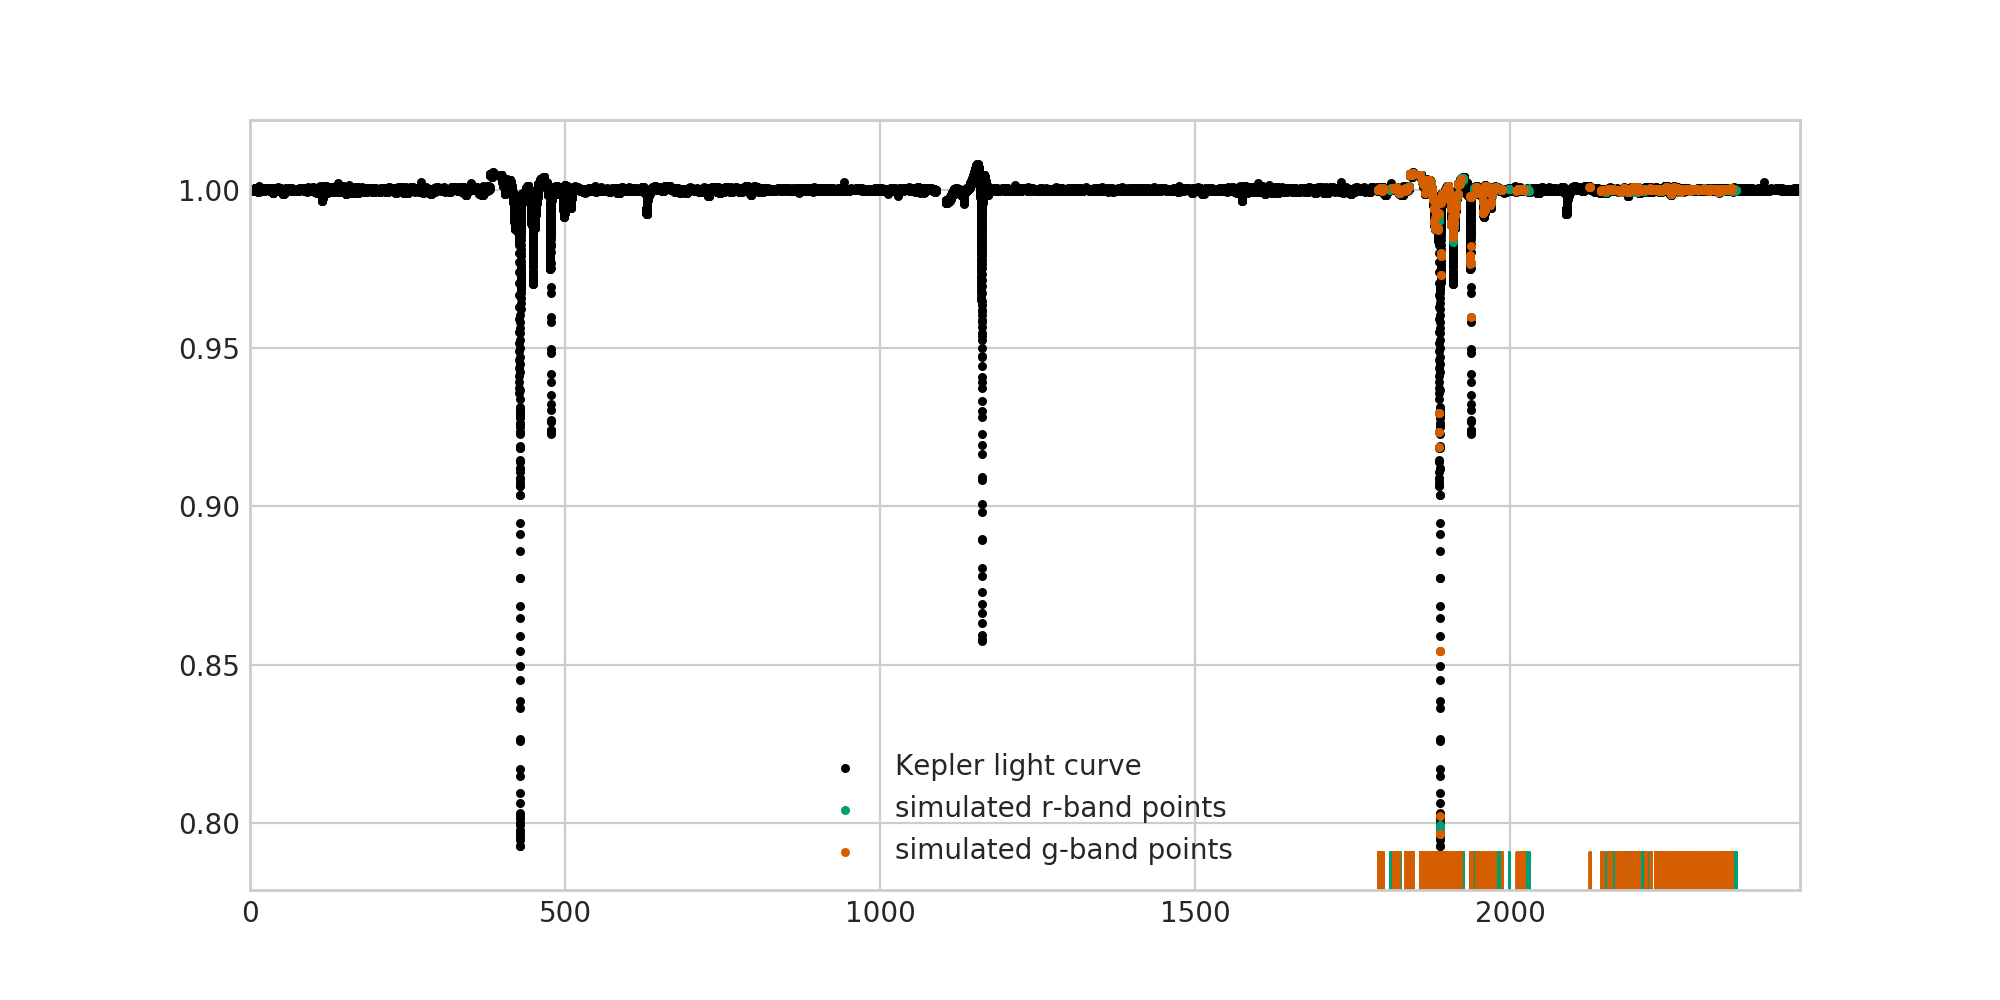

1155


<IPython.core.display.Javascript object>


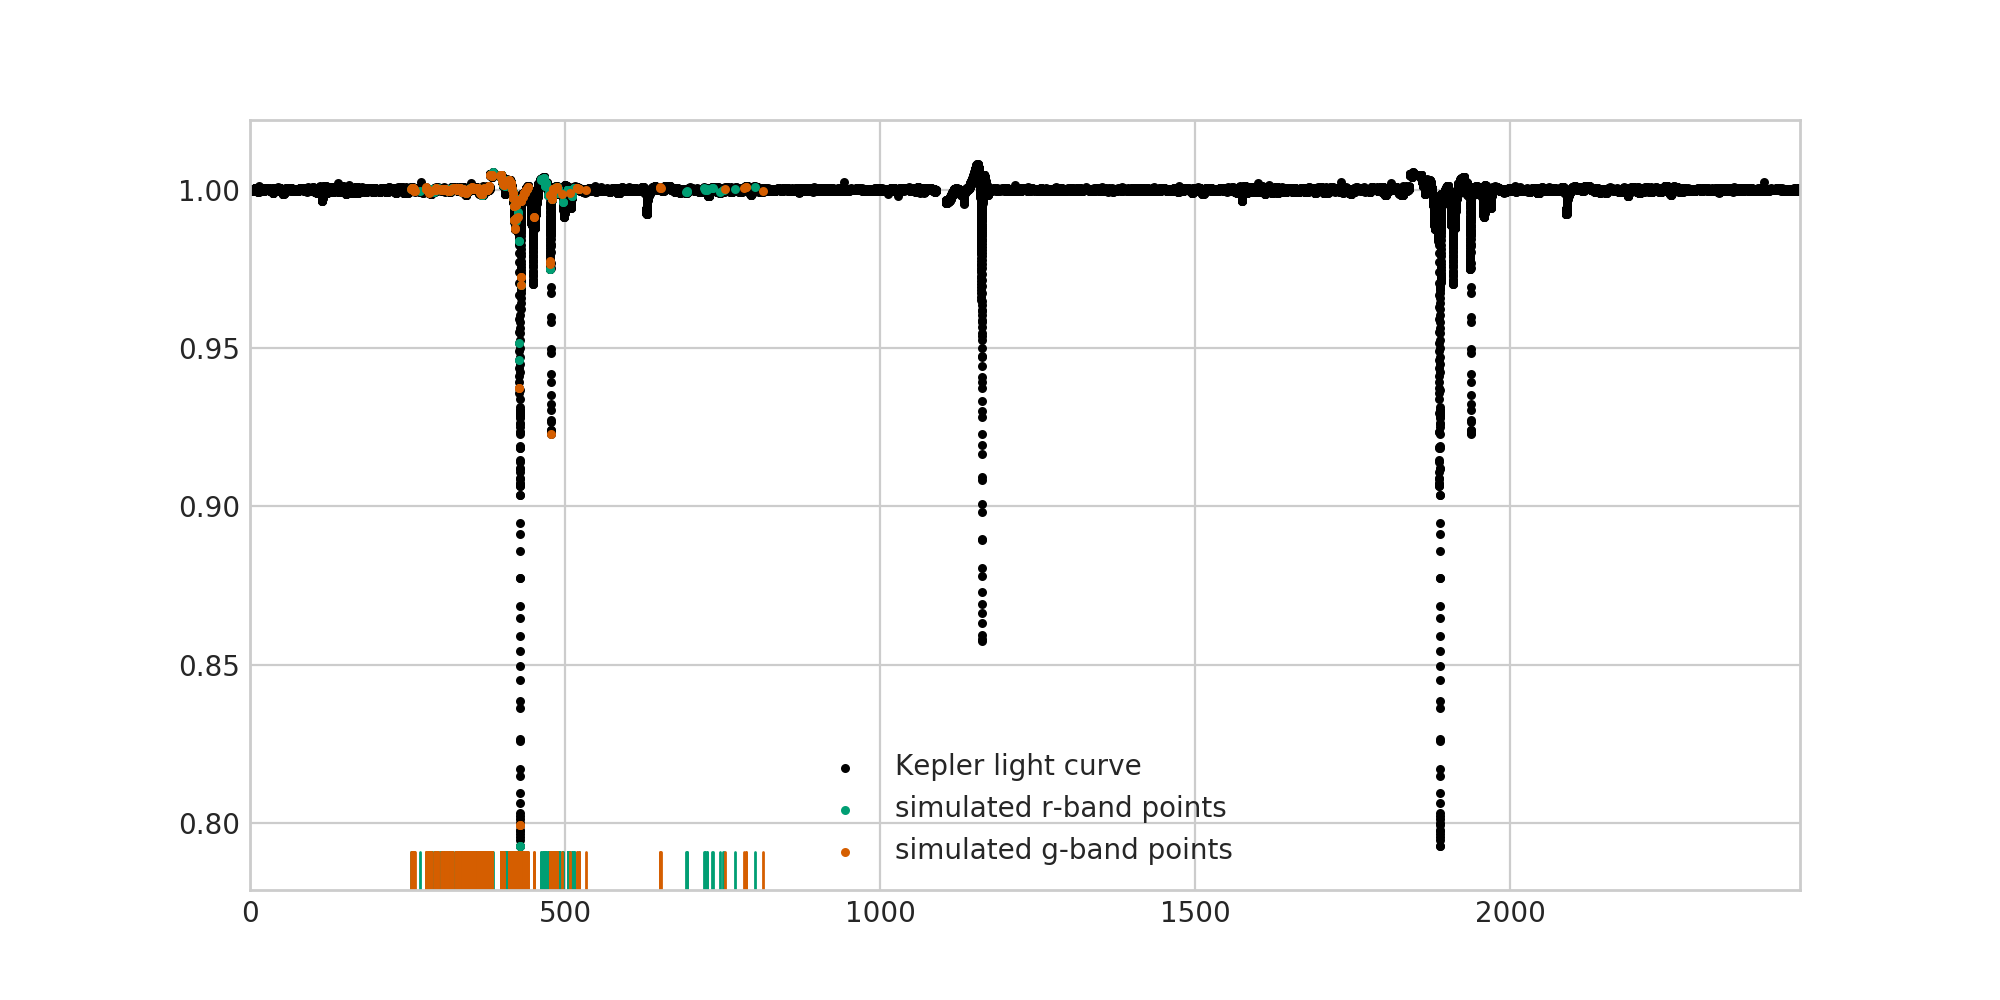

1392


<IPython.core.display.Javascript object>


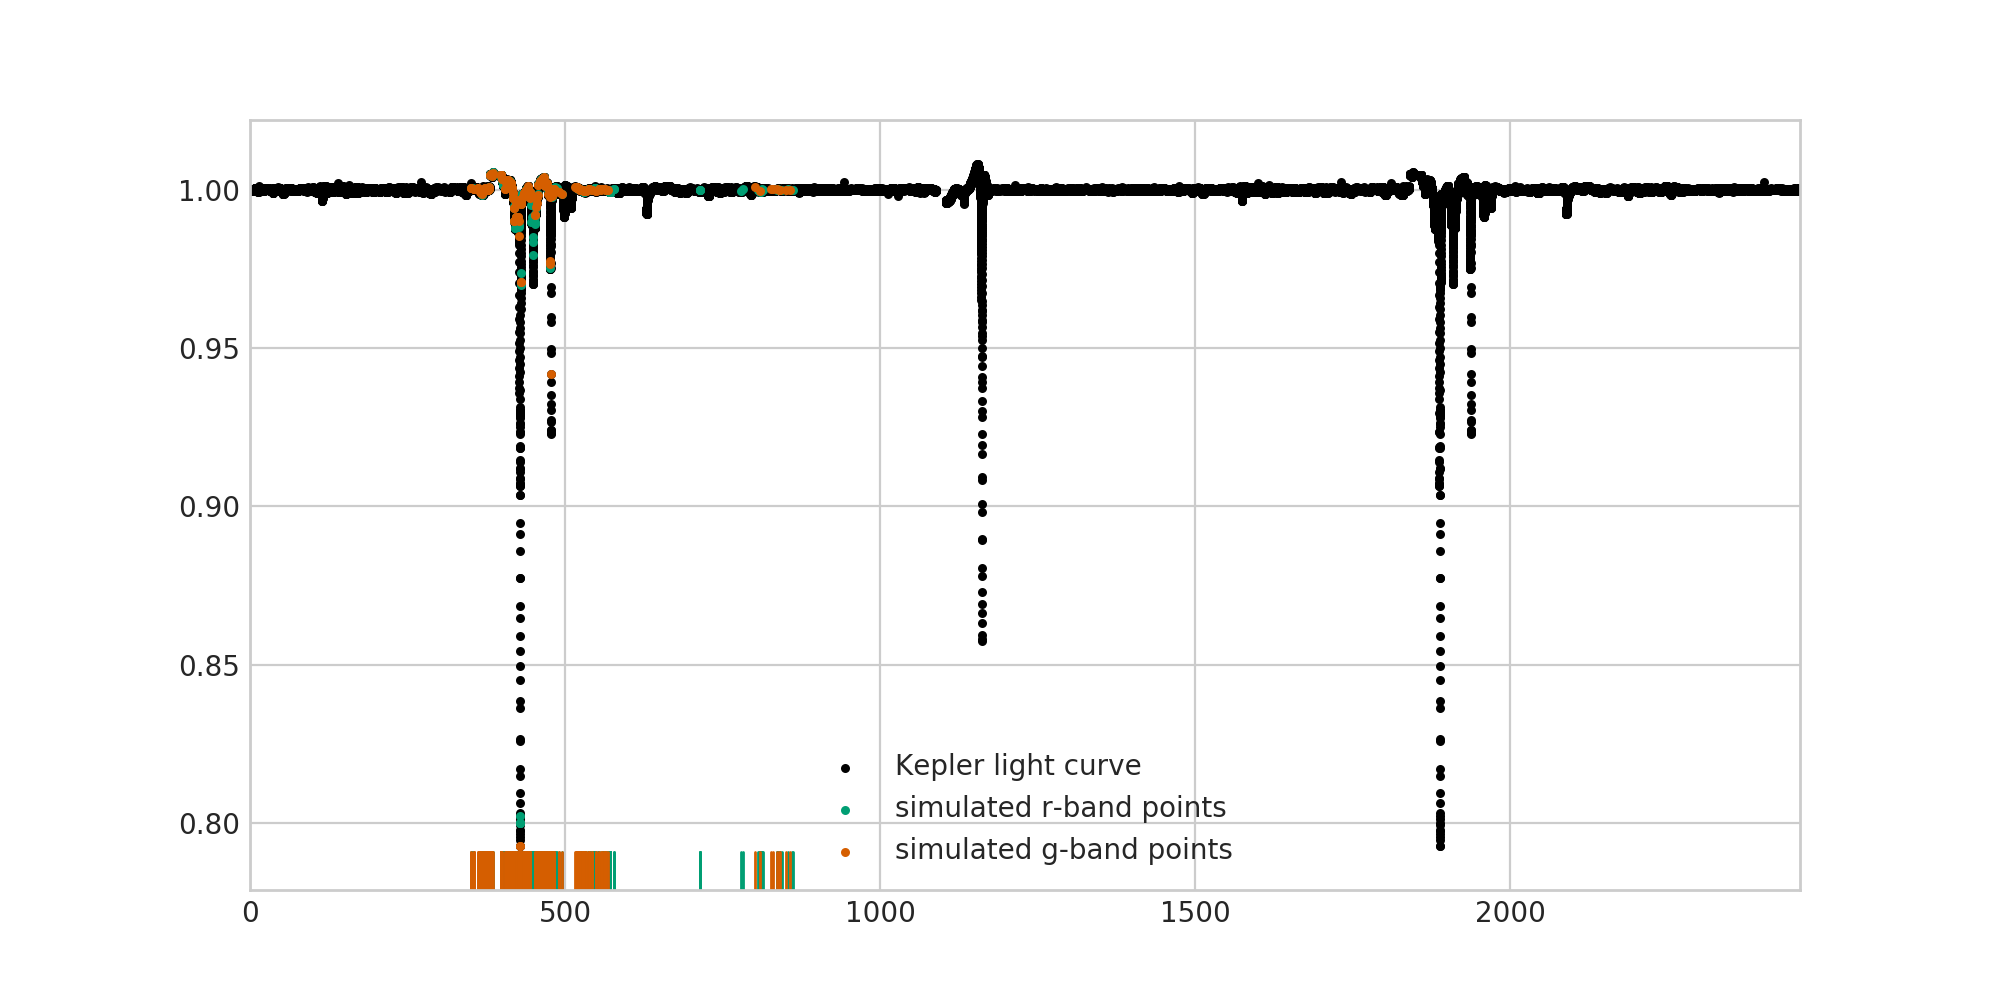

1032


<IPython.core.display.Javascript object>


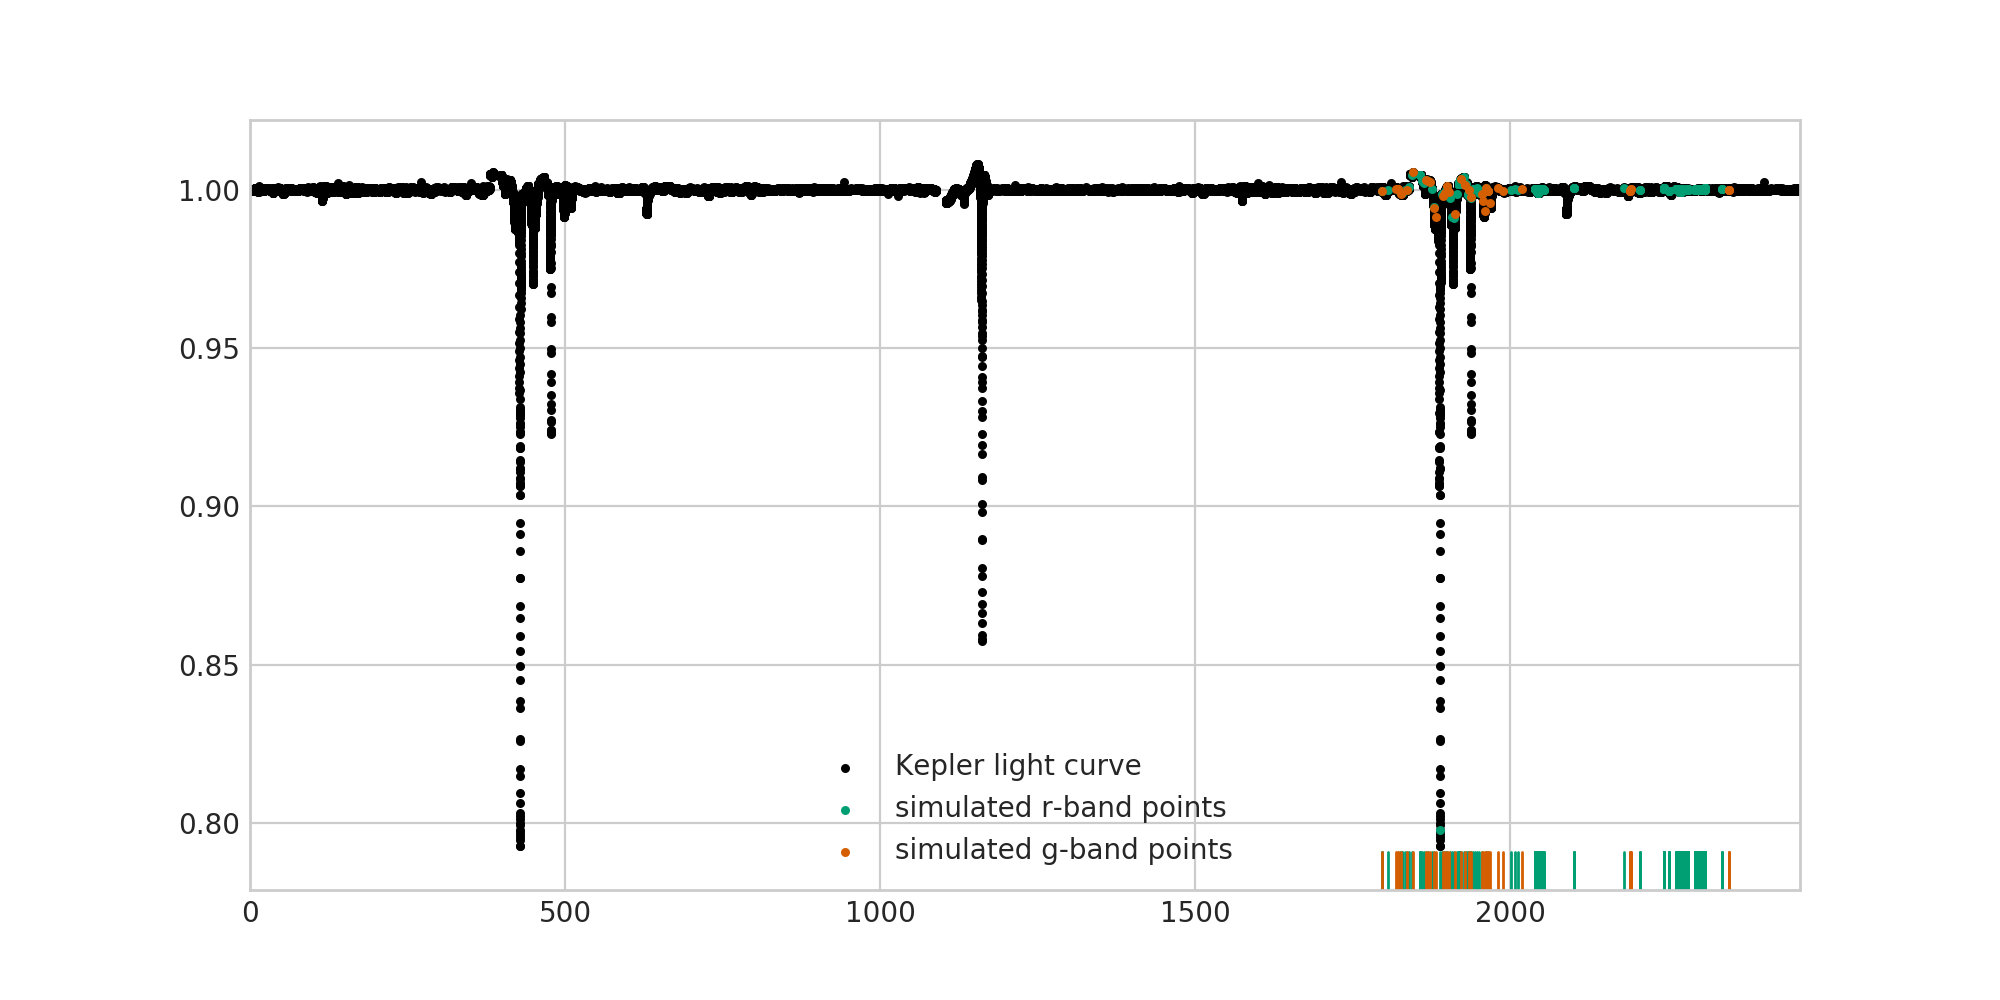

1018


<IPython.core.display.Javascript object>


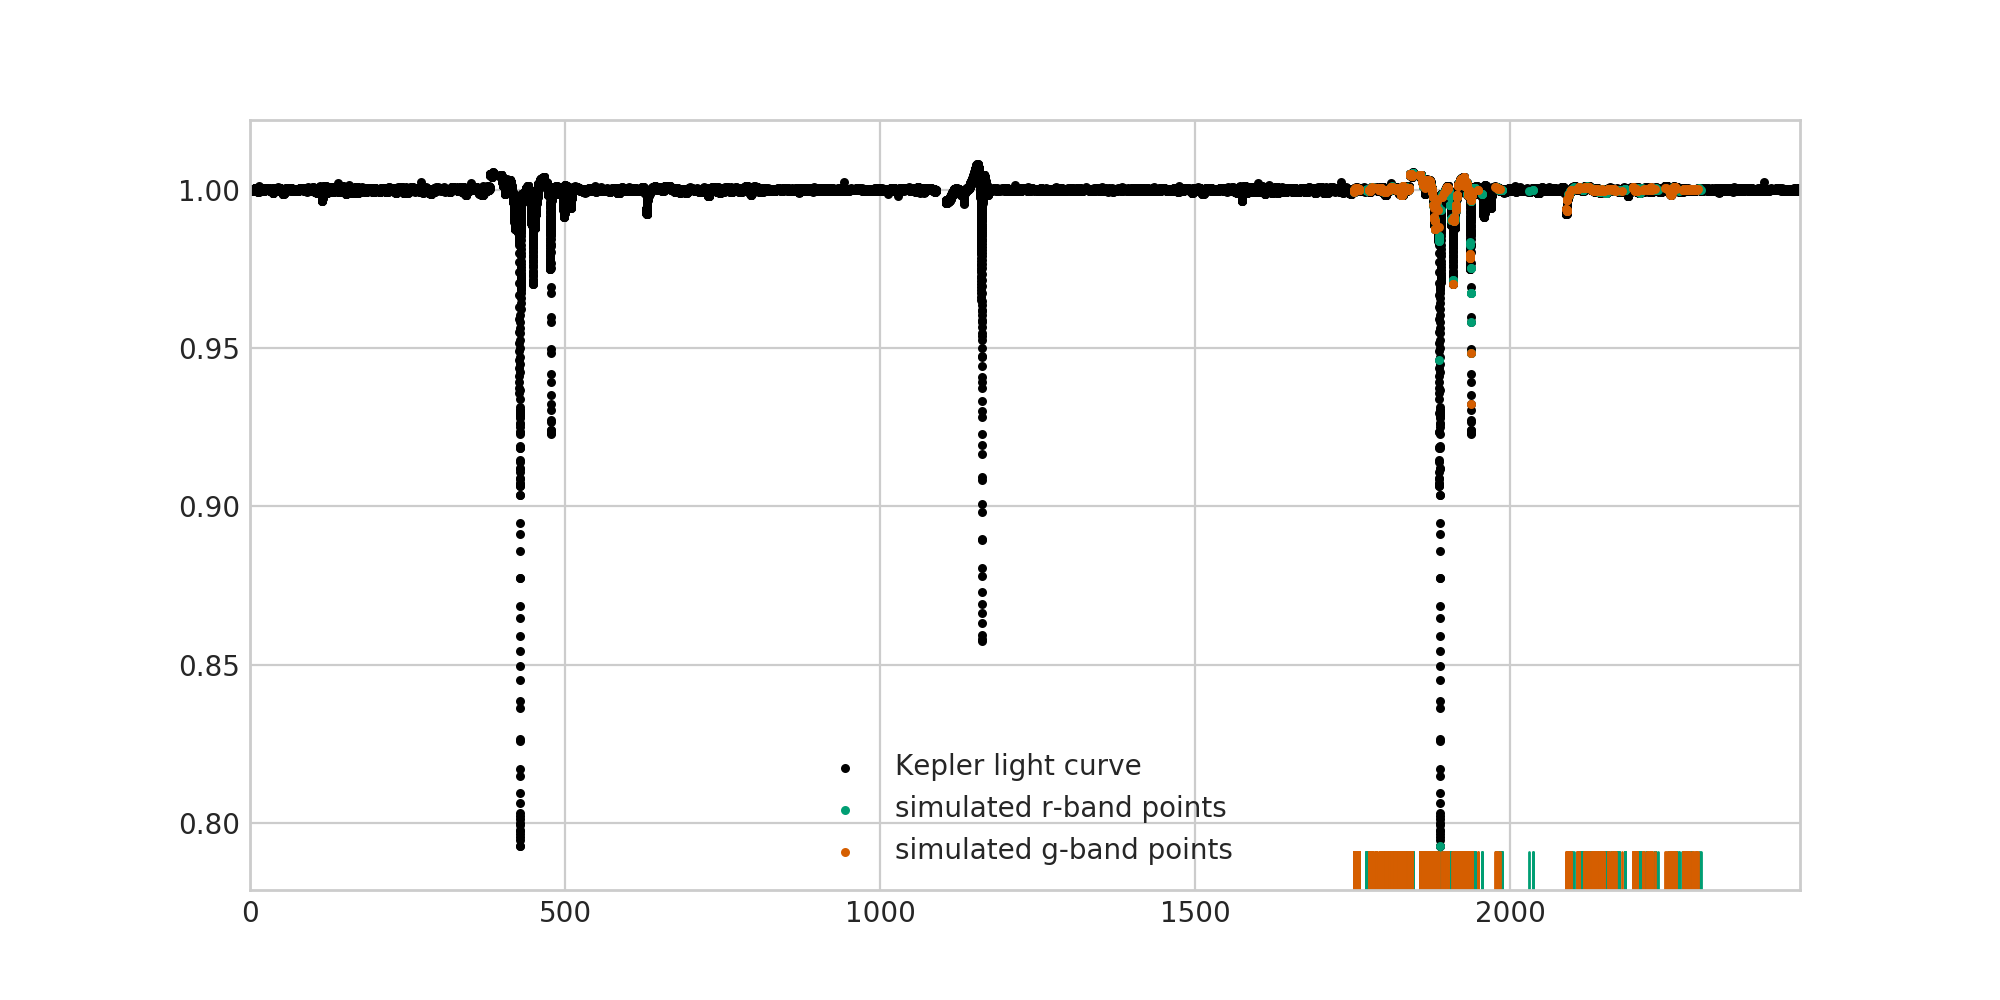

1403


<IPython.core.display.Javascript object>


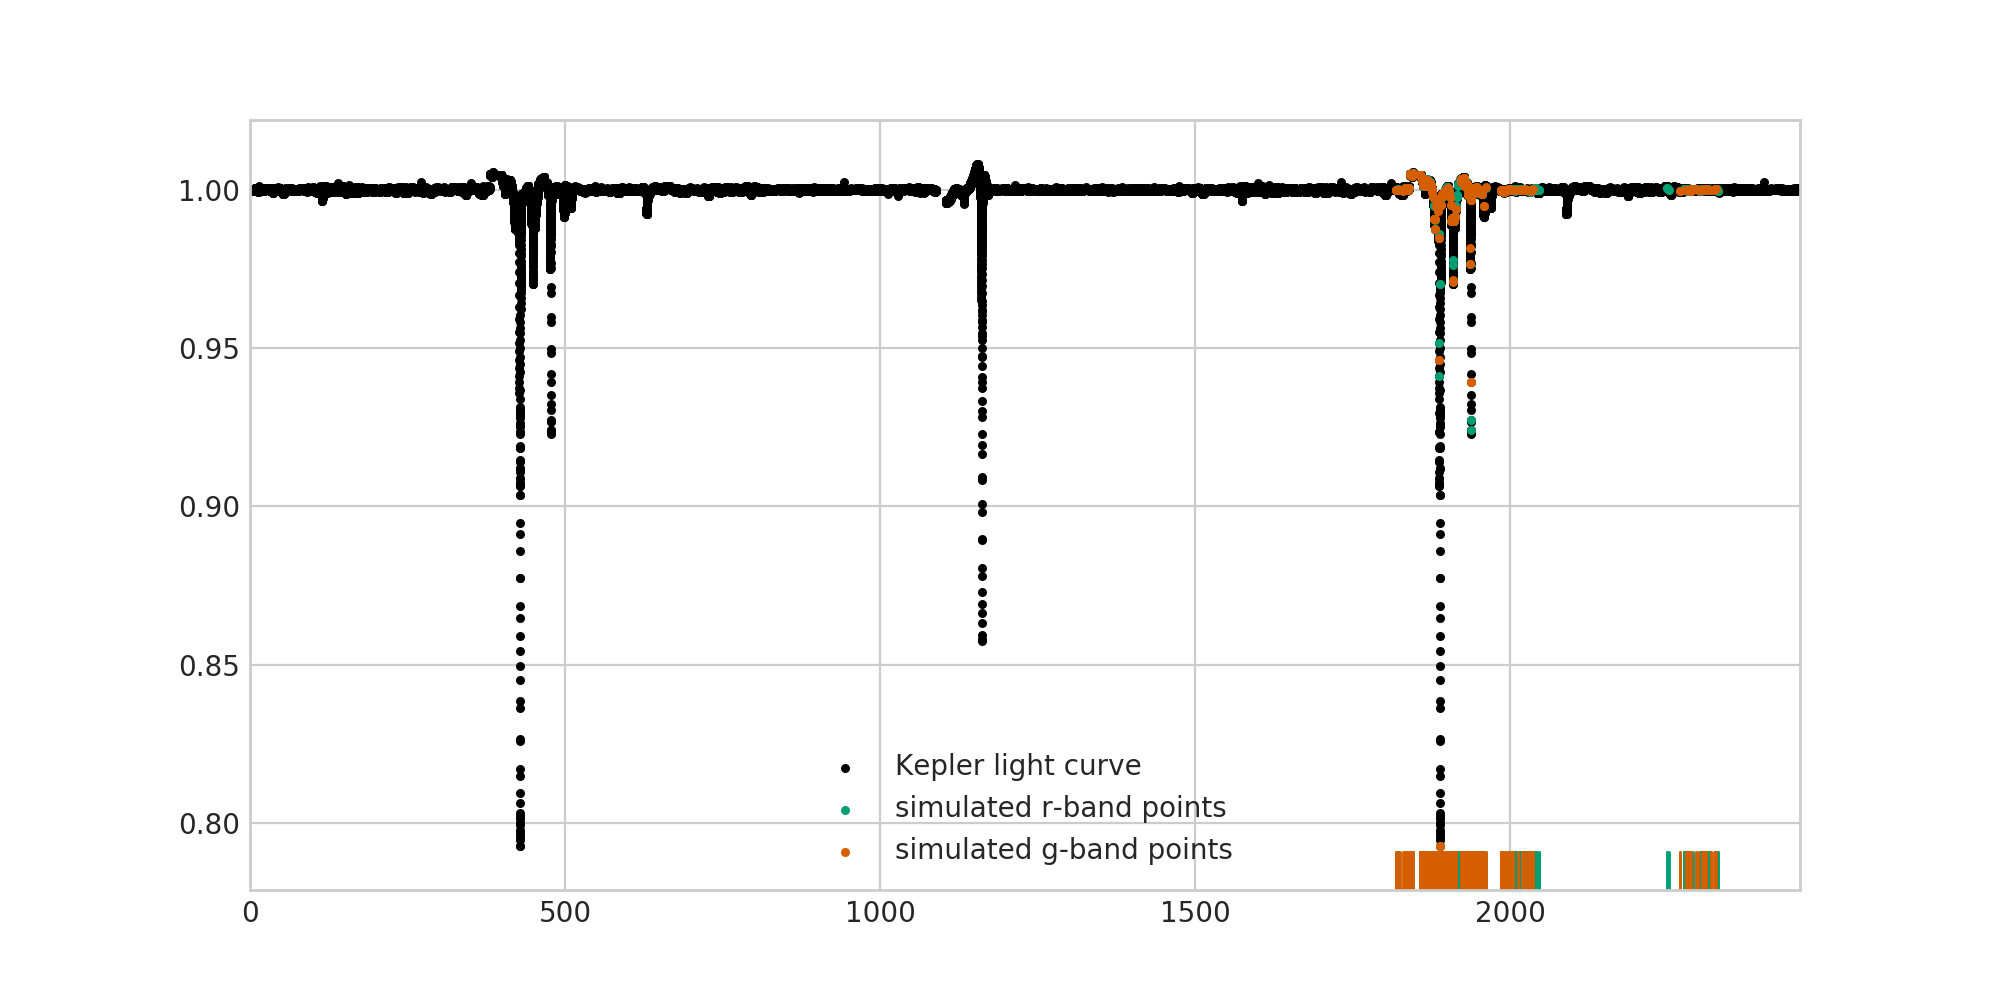

1118


<IPython.core.display.Javascript object>


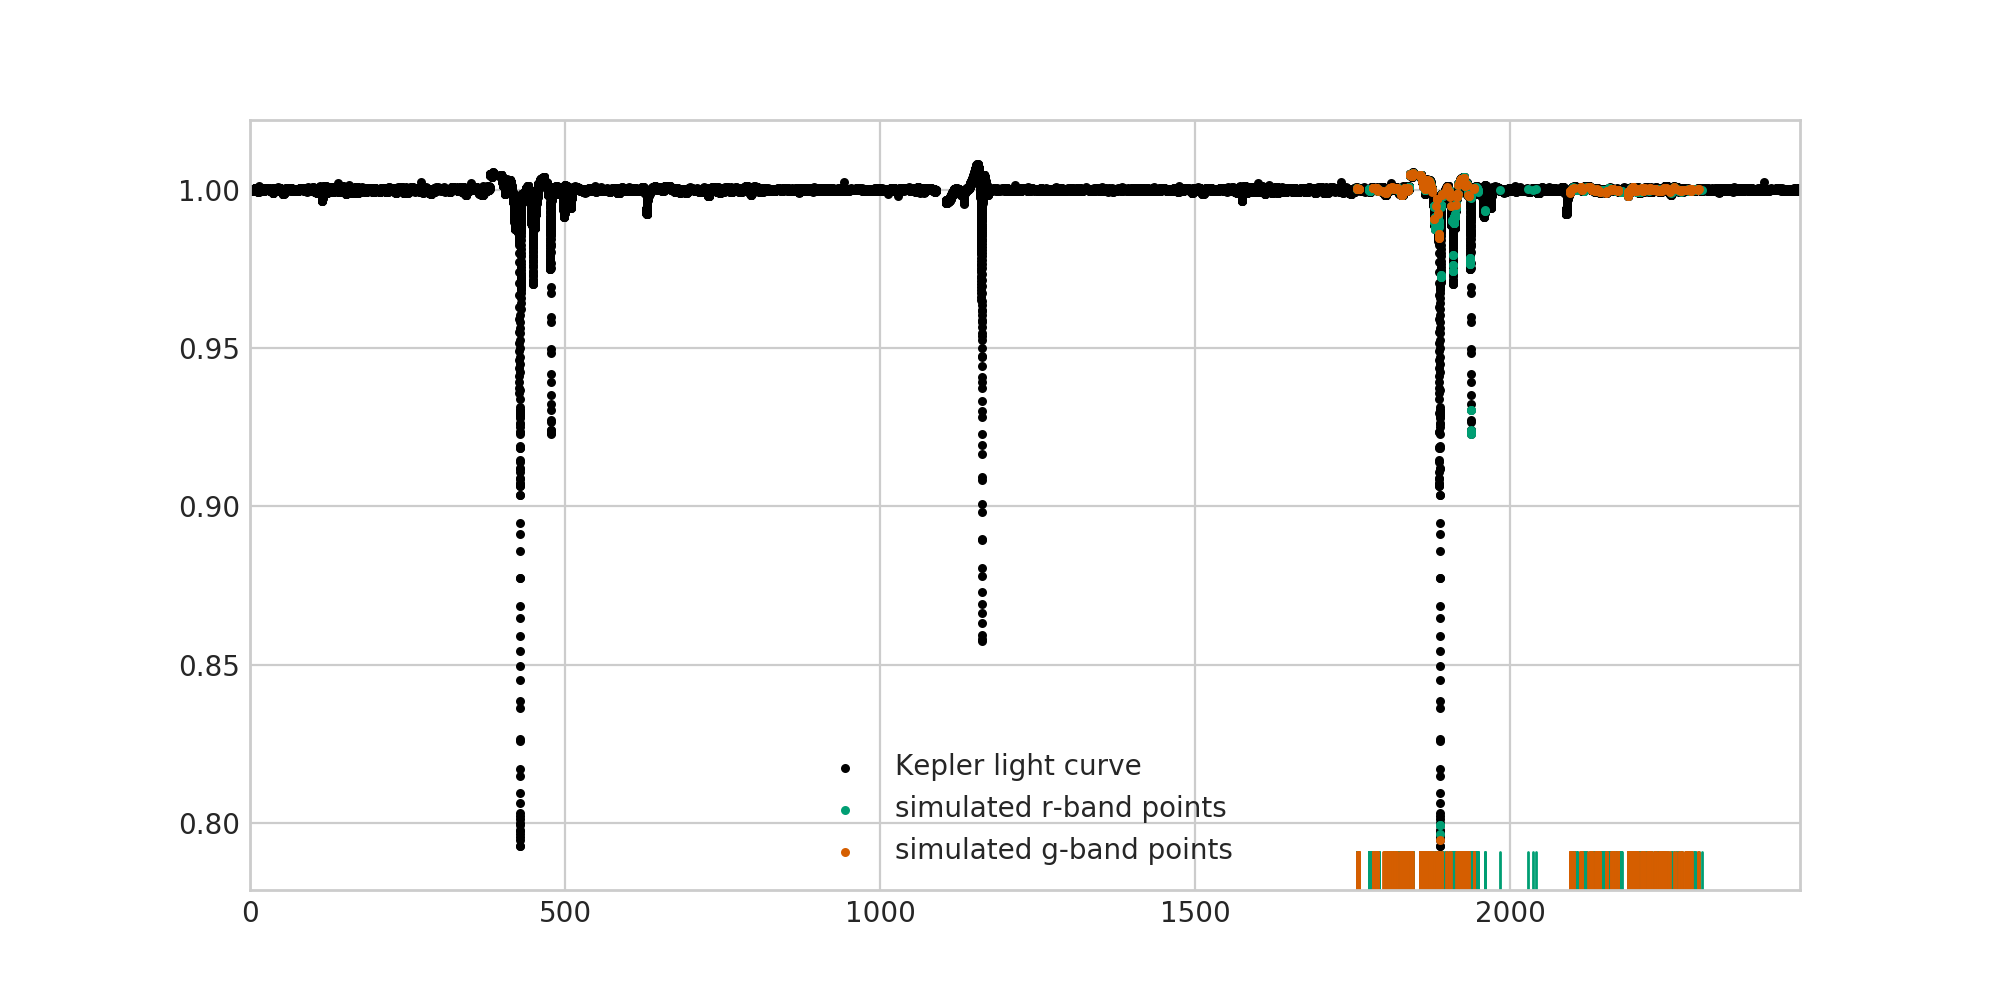

1334


<IPython.core.display.Javascript object>


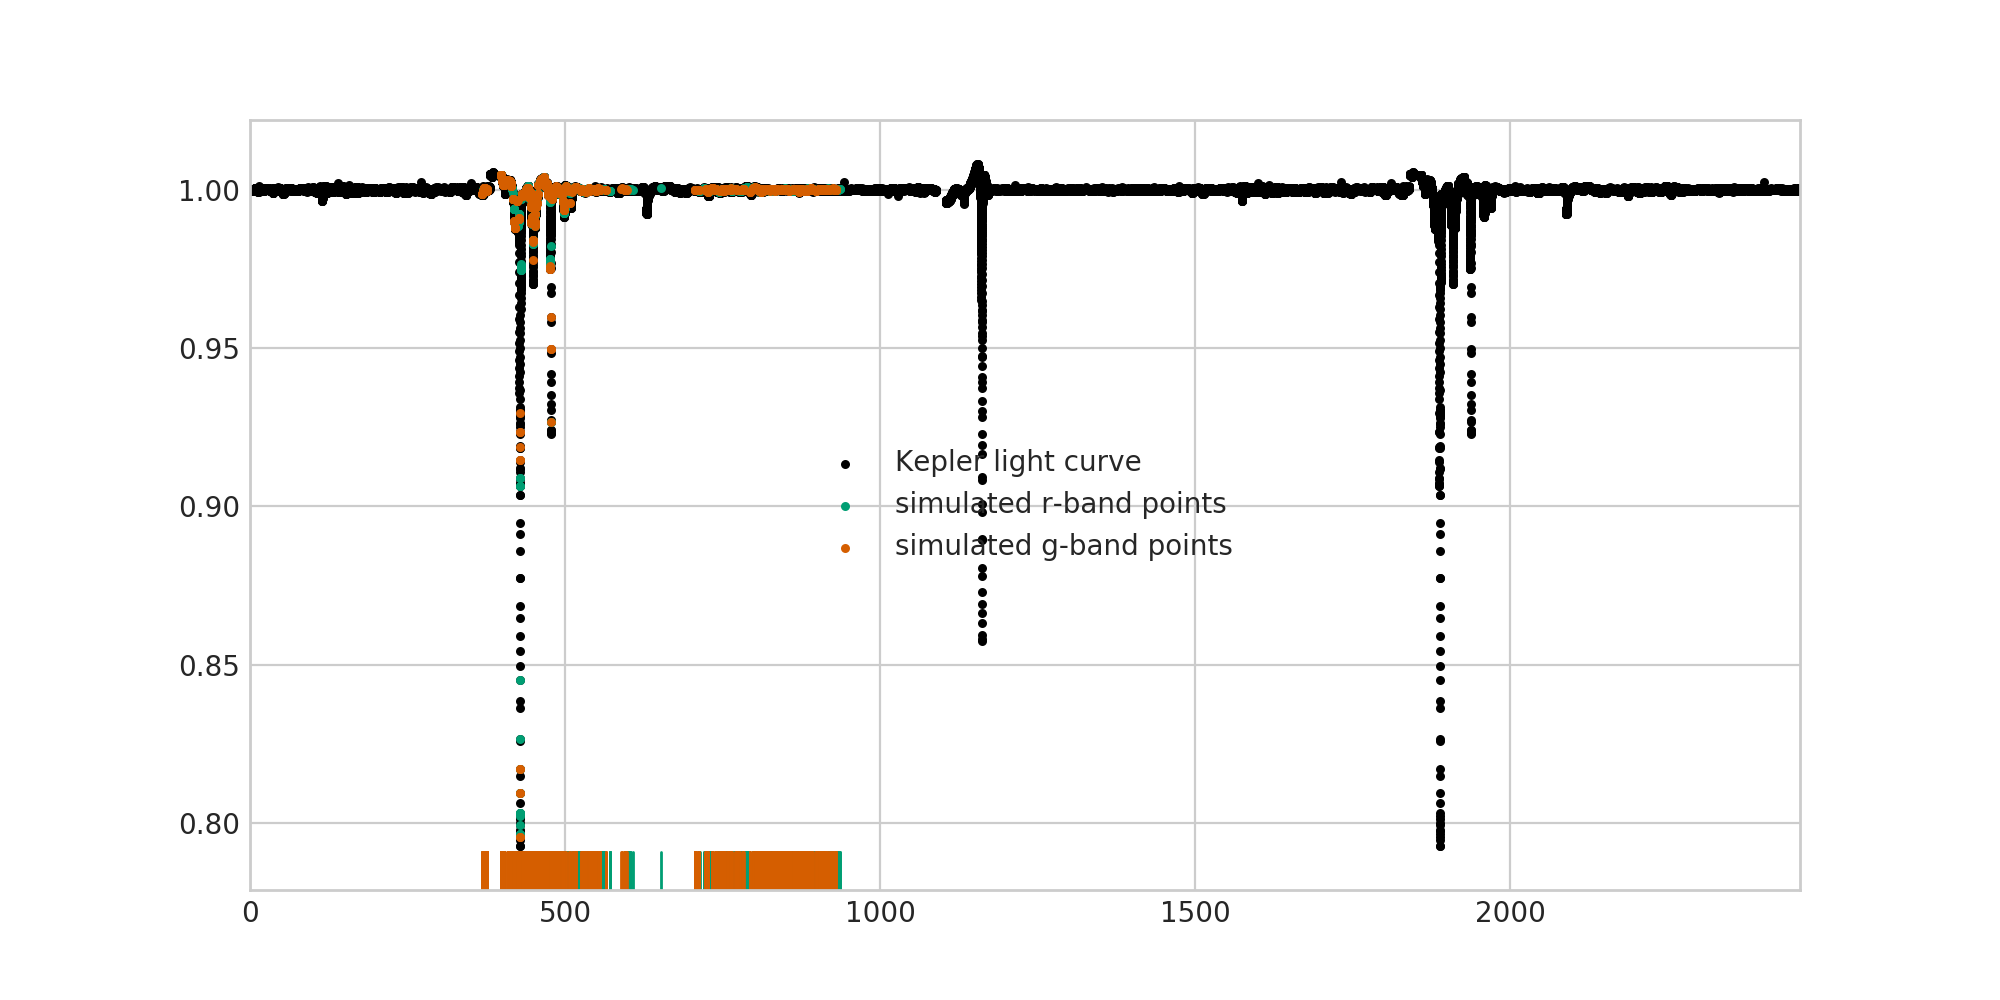

1115


<IPython.core.display.Javascript object>


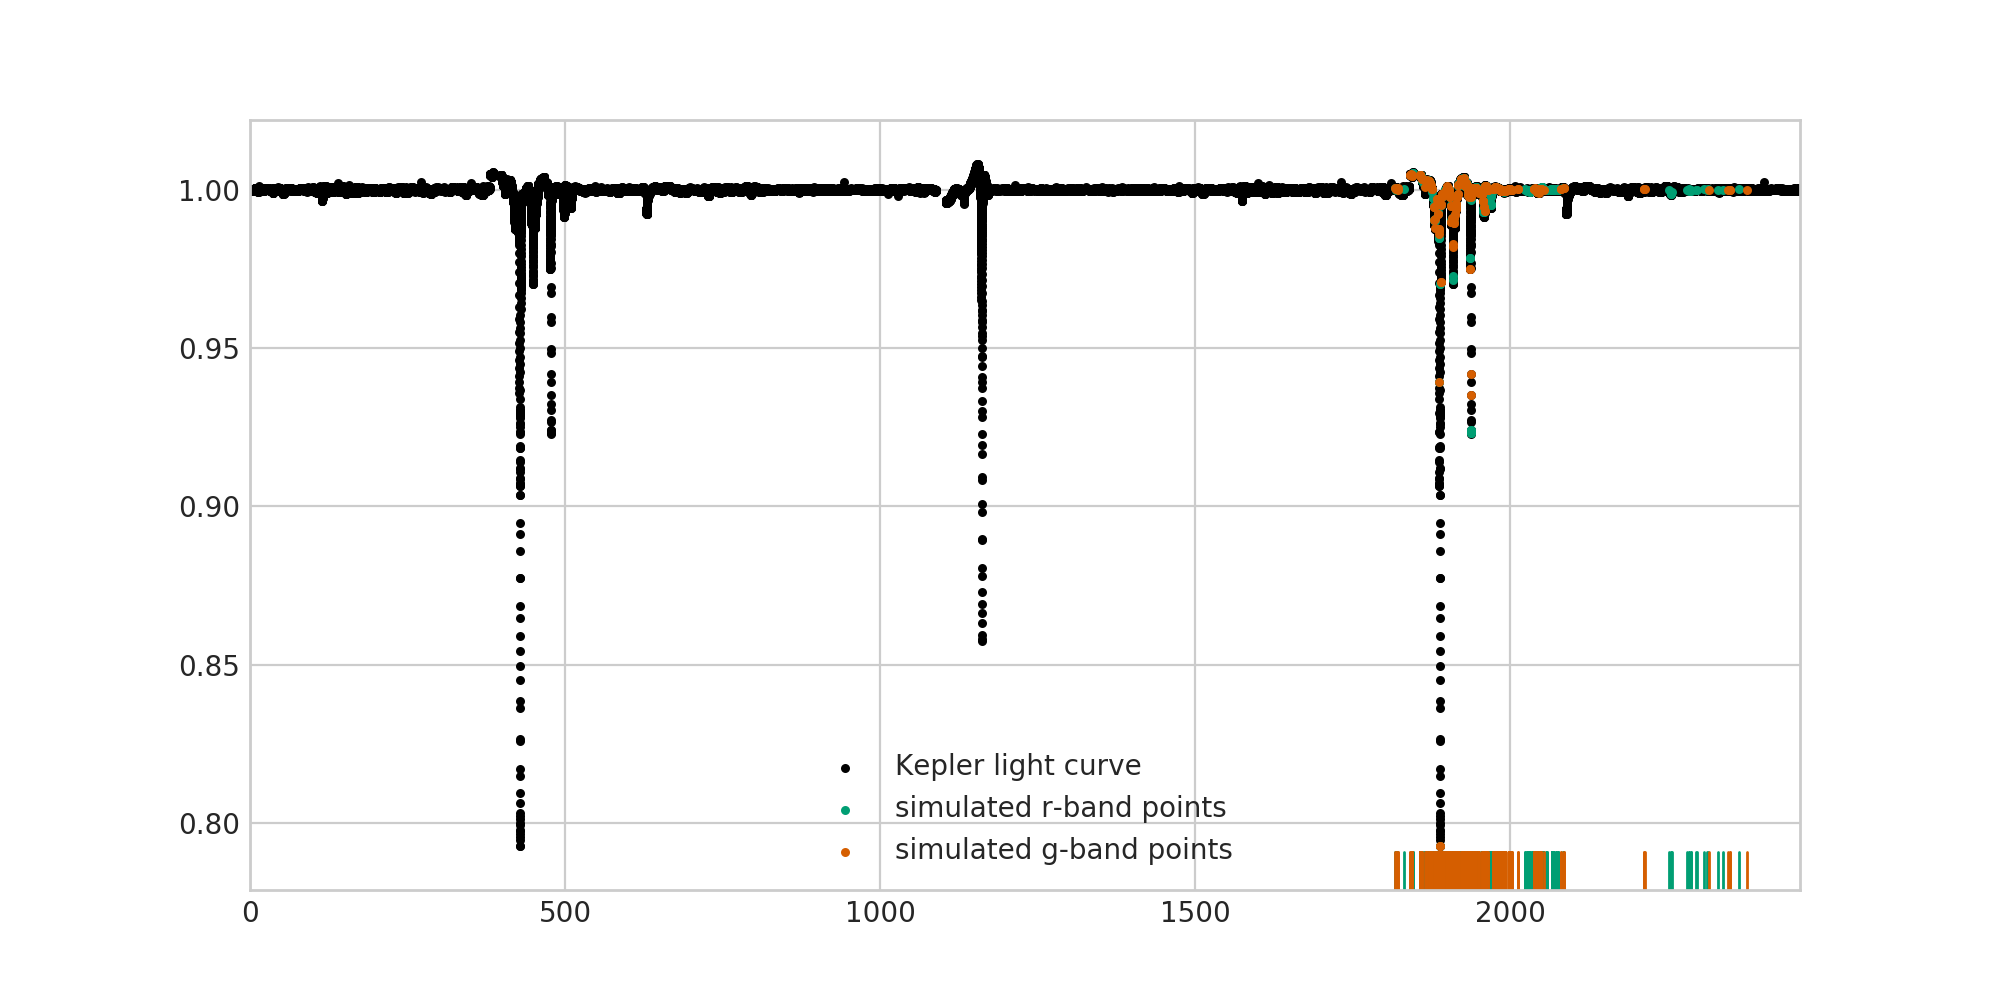

1300


<IPython.core.display.Javascript object>


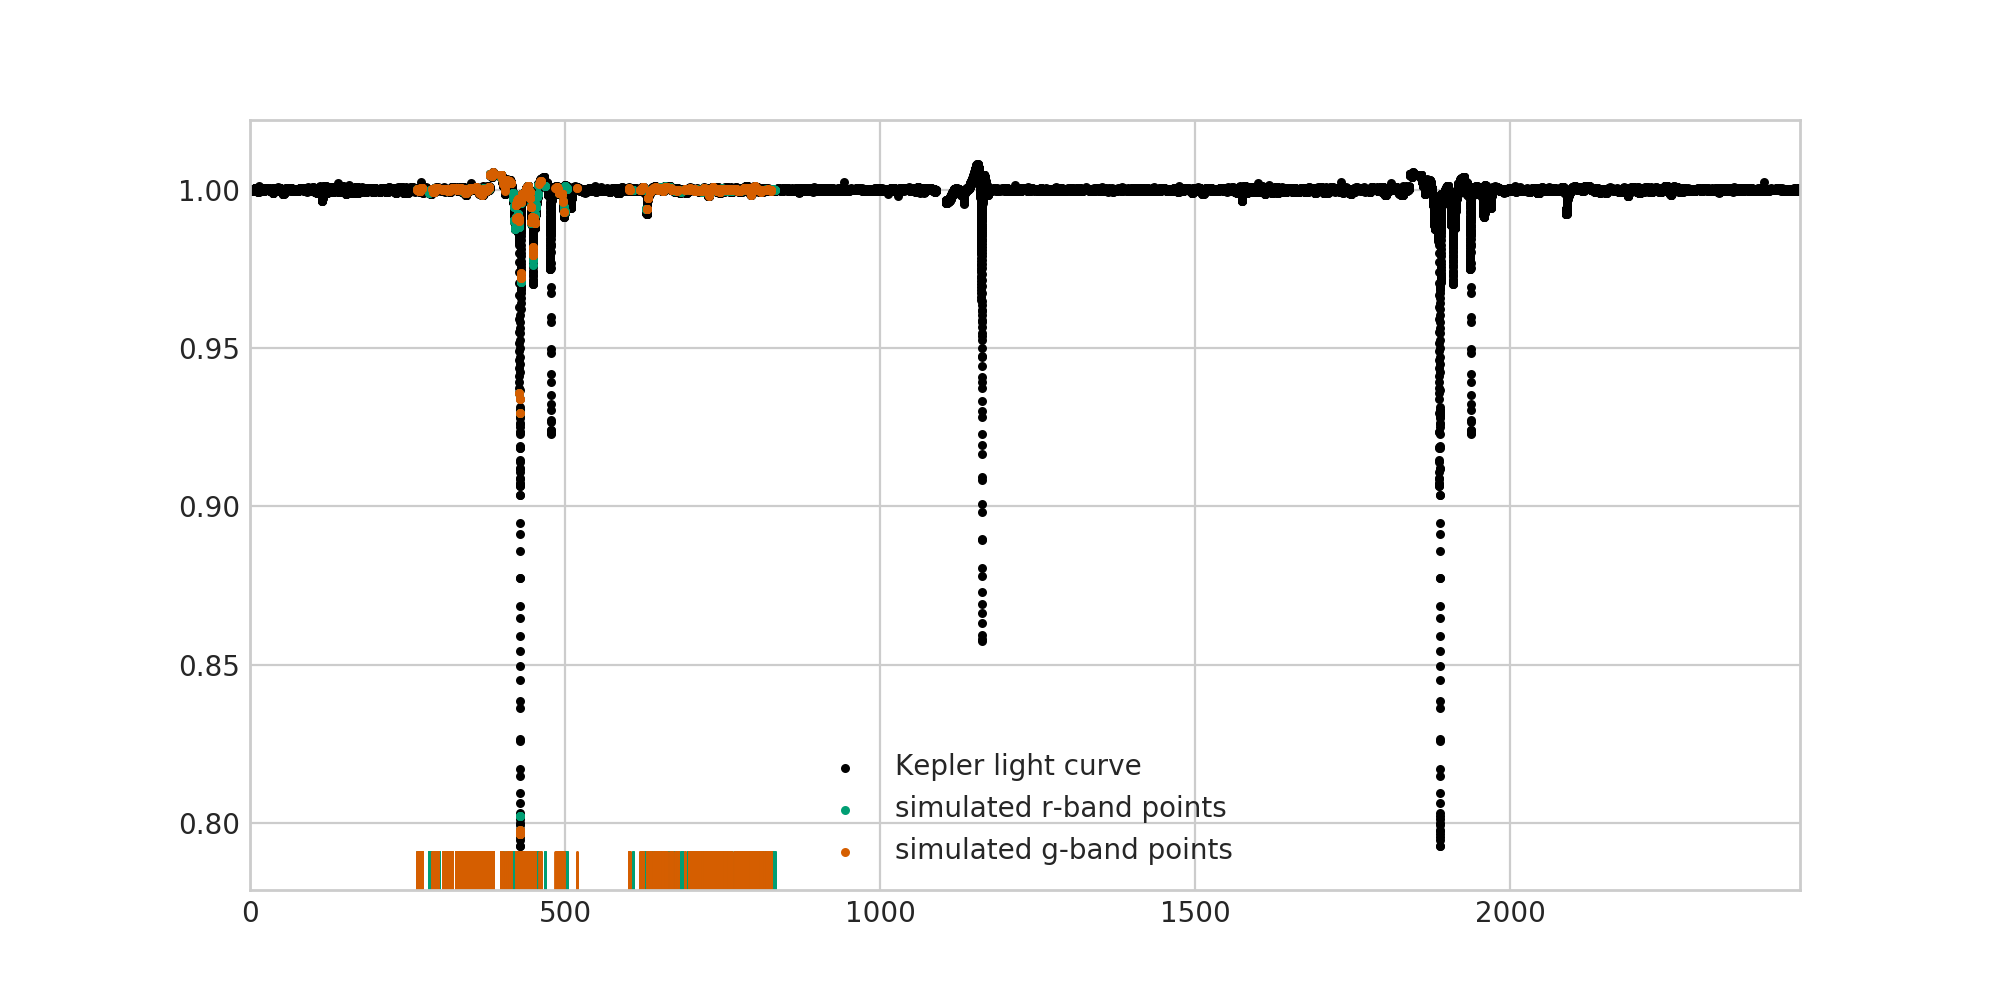

In [141]:
for lc_ztf_r, lc_ztf_g in zip(ztf_with_dips_r[(ztf_with_dips_npoints > 1000)][:10],ztf_with_dips_g[(ztf_with_dips_npoints > 1000)][:10]):
    print(len(lc_ztf_r.time))
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    plot_cadence(kepler_lc, ztf_boyajian_r=lc_ztf_r, ztf_boyajian_g=lc_ztf_g, band="both", ax=ax)

## Running Kyle's Dip Detection Algorithm

We want to find Boyajian's star using Kyle's dip detection algorithm.

This takes as inputs:
* MJD g-band  and r-band
* magnitude in g-band and r-band
* mag_err in g-band and r-band
* positions on the CCD in g and r
* catflags in g-band and r-band (put in all zeros)

Fake positions and catflags:
* xpos = 1000, ypos = 1000
* catflag_g = 0.0
* catflag_r = 0.0




In [119]:
lc1 = ztf_boyajian_g_examples[0]

In [120]:
lc1.flux_err

array([0.12245544, 0.12294076, 0.13029981, 0.14947748, 0.123066  ,
       0.12027334, 0.13441946, 0.12845743, 0.14017309, 0.13468988,
       0.12621491, 0.1406765 , 0.13147677, 0.13999462, 0.13084859,
       0.15499747, 0.14147669, 0.14960051, 0.12448227, 0.14311385,
       0.11257017, 0.1441505 , 0.14542186, 0.13467628, 0.13998935,
       0.13795018, 0.10891473, 0.11906584])

In [167]:
lc_dict_keys = ["mjd_g", "mag_g", "magerr_g", "xpos_g", "ypos_g", "catflags_g",
                "mjd_r", "mag_r", "magerr_r", "xpos_r", "ypos_r", "catflags_r"]

In [168]:
lc_all_dict = []

for i in range(len(ztf_boyajian_g_examples)):
    lc_tmp = {"mjd_g": ztf_boyajian_g_examples[i].time, "mag_g": ztf_boyajian_g_examples[i].flux,
                  "magerr_g": ztf_boyajian_g_examples[i].flux_err,
                  "xpos_g": np.ones_like(ztf_boyajian_g_examples[i].time)*1000,
                  "ypos_g": np.ones_like(ztf_boyajian_g_examples[i].time)*1000,
                  "catflags_g":  np.zeros_like(ztf_boyajian_g_examples[i].time),
                  "mjd_r": ztf_boyajian_r_examples[i].time, "mag_r": ztf_boyajian_r_examples[i].flux,
                  "magerr_r": ztf_boyajian_r_examples[i].flux_err,
                  "xpos_r": np.ones_like(ztf_boyajian_r_examples[i].time)*1000,
                  "ypos_r": np.ones_like(ztf_boyajian_r_examples[i].time)*1000,
                  "catflags_r":  np.zeros_like(ztf_boyajian_r_examples[i].time)}
    
    lc_all_dict.append(lc_tmp)

In [169]:
import dipper

In [45]:
#from importlib import reload
#reload(dipper)

In [124]:
%matplotlib inline

In [125]:
idx_dip = np.where(flare_present_r)[0]

for idx in idx_dip[:10]:
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    plot_cadence(kepler_lc, ztf_boyajian_r_examples[idx], ztf_boyajian_g_examples[idx], "both", ax=ax)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f1715a0f9e0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f171550d560> (for post_execute):


KeyboardInterrupt: 

In [146]:
lc_dip = lc_all_dict[5000]

<ErrorbarContainer object of 3 artists>

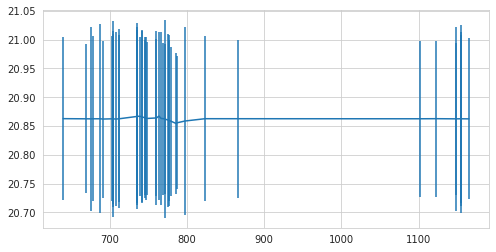

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.errorbar(lc_dip["mjd_g"], lc_dip["mag_g"], yerr=lc_dip["magerr_g"])
#ax.set_xlim(1510, 1525)

In [96]:
lc_dip

{'mjd_g': array([1421.81254816, 1421.81254816, 1421.83298084, ..., 1982.6319161 ,
        1982.65235047, 1982.65235047]),
 'mag_g': array([15.65925145, 15.65925145, 15.65934211, ..., 15.65961349,
        15.65938008, 15.65938008]),
 'magerr_g': array([0.01243593, 0.01199589, 0.01244333, ..., 0.01241588, 0.01242207,
        0.01197825]),
 'xpos_g': array([1000., 1000., 1000., ..., 1000., 1000., 1000.]),
 'ypos_g': array([1000., 1000., 1000., ..., 1000., 1000., 1000.]),
 'catflags_g': array([0., 0., 0., ..., 0., 0., 0.]),
 'mjd_r': array([1421.81254816, 1421.81254816, 1421.85341351, ..., 1989.49789506,
        1989.55919828, 1989.55919828]),
 'mag_r': array([15.22629571, 15.22629571, 15.22623938, ..., 15.22622305,
        15.22643709, 15.22643709]),
 'magerr_r': array([0.01092489, 0.01092624, 0.01092547, ..., 0.01149345, 0.01149387,
        0.01092738]),
 'xpos_r': array([1000., 1000., 1000., ..., 1000., 1000., 1000.]),
 'ypos_r': array([1000., 1000., 1000., ..., 1000., 1000., 1000.]),
 

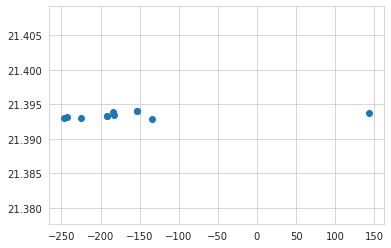

In [140]:
plt.figure()
plt.scatter(lc_dip["mjd_g"], lc_dip["mag_g"])

In [106]:
dipper.parse_observations(lc_dip["mjd_g"], lc_dip["mag_g"], lc_dip["magerr_g"], 
                          lc_dip["xpos_g"], lc_dip["ypos_g"], lc_dip["catflags_g"])

(array([1421.81254816, 1421.83298084, 1421.85341351, 1421.87384618,
        1421.89427896, 1421.91471163, 1422.81374936, 1422.83418193,
        1422.8546147 , 1422.87504737, 1422.89548003, 1423.81495022,
        1423.83538288, 1423.85581545, 1423.87624821, 1423.89668087,
        1424.81615085, 1424.83658361, 1424.85701617, 1424.87744893,
        1424.89788159, 1424.91831415, 1425.81735128, 1425.83778404,
        1425.85821669, 1425.87864925, 1425.899082  , 1425.91951466,
        1426.83898436, 1426.85941691, 1426.87984957, 1426.90028222,
        1427.77888636, 1427.84018431, 1427.86061705, 1427.8810496 ,
        1428.78008635, 1428.82095164, 1428.84138428, 1428.86181693,
        1428.88224957, 1444.73797624, 1445.86177149, 1446.88340348,
        1447.76200721, 1447.78243975, 1447.88460305, 1448.78363943,
        1448.80407207, 1448.84493736, 1448.86537   , 1449.82570454,
        1449.88700248, 1451.72594132, 1451.76680653, 1451.80767183,
        1451.82810458, 1451.84853723, 1451.86896

In [175]:
len(lc_all_dict)

10000

In [173]:
dip_idx = []
for i,lc in enumerate(lc_all_dict):
    #if i in idx_dip:
    #print("Running on light curve %i"%i)
    #print("flare present in %i"%i)
    res = dipper.analyze_dip_row(lc, min_dip_time=2, 
                                 min_num_observations=3, 
                                 threshold=2.5)
    #print(res)
    if res["score"] > 0:
        print(i)
        print(res)
        dip_idx.append(i)
    #else:
    #    continue
    

36
{'intmag': 0.3046952925051112, 'start_mjd': 59.01187843060325, 'end_mjd': 61.13695829986682, 'nobs': 3, 'score': 13.719129995550725, 'significance': 10.87567659690928, 'reference_stability': 1.095388416731211, 'num_dips': 3}
5718
{'intmag': 0.3302563829164403, 'start_mjd': 1518.7052257162723, 'end_mjd': 1520.7077052857858, 'nobs': 5, 'score': 14.11961633639562, 'significance': 26.722782865993867, 'reference_stability': 1.0062298608716864, 'num_dips': 1}
6311
{'intmag': 0.08162608874864252, 'start_mjd': 58.99144489288301, 'end_mjd': 61.01435746716015, 'nobs': 3, 'score': 3.8502711311867794, 'significance': 5.394113039521719, 'reference_stability': 1.1296129830950379, 'num_dips': 3}
6649
{'intmag': 0.2303272759066621, 'start_mjd': 1518.7052257162723, 'end_mjd': 1520.7894390865986, 'nobs': 3, 'score': 17.514246285213243, 'significance': 16.657268673147797, 'reference_stability': 1.0749013271892112, 'num_dips': 1}
8823
{'intmag': 0.29700181853828, 'start_mjd': 1518.6847923751848, 'end_m

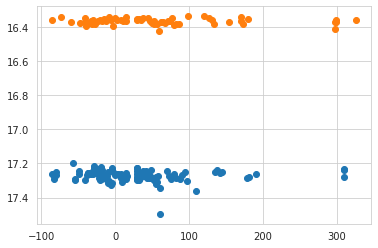

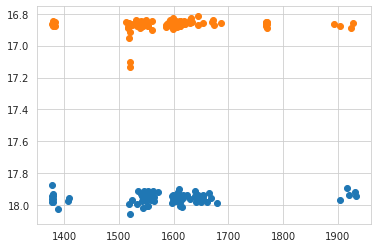

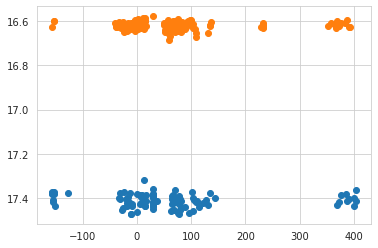

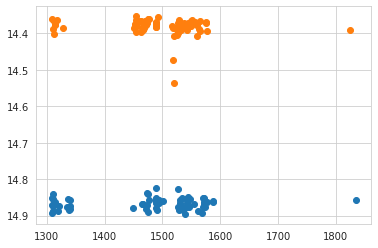

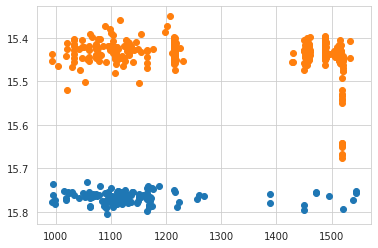

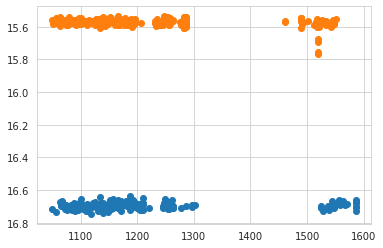

In [174]:
for idx in dip_idx:
    lc = lc_all_dict[idx]
    plt.figure()
    plt.errorbar(lc["mjd_g"], lc["mag_g"], fmt="o")
    plt.errorbar(lc["mjd_r"], lc["mag_r"], fmt="o")
    plt.gca().invert_yaxis()
    

Plans:
* need a data set of ZTF cadences that we understand where it comes from
* take Boyajian's star and scale it to deeper dips (unit magnitudes)
* take Boyajian's star and scale it to longer dips (unit days)
* number of dips per year
* take one of the Boyajian's star dips, and clip that out and scale
* can we separate signal-to-noise and cadence pieces?

